In [ ]:
import cv2
from PIL import Image
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch
import numpy as np
from diffusers.utils import load_image

image = Image.open("test2.png").convert("RGB")
image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
image = Image.fromarray(image)

controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-mlsd", torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

pipe.enable_model_cpu_offload()

image = pipe("Bedroom with Dark Blue bed and Dark grey walls", image, num_inference_steps=20).images[0]

image.save('out.png')


OSError: lllyasviel/sd-controlnet-seg does not appear to have a file named config.json.

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.4.0+cu118 with CUDA 1108 (you have 2.7.0+cu118)
    Python  3.9.13 (you have 3.9.6)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "c:\Interior\.venv\lib\site-packages\xformers\__init__.py", line 57, in _is_triton_available
    import triton  # noqa
ModuleNotFoundError: No module named 'triton'


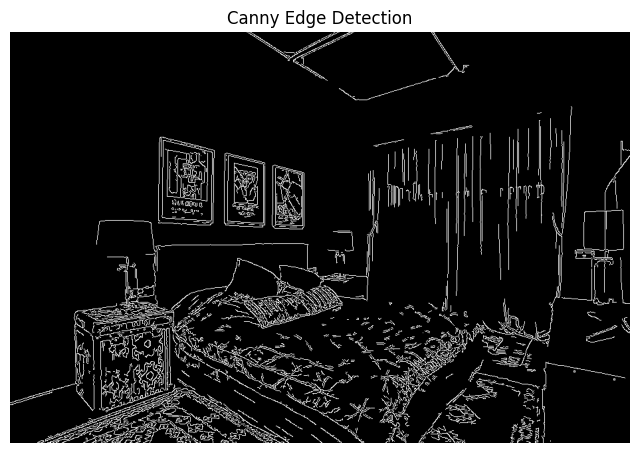

In [4]:
import cv2
import torch
import matplotlib.pyplot as plt
from diffusers import (
    ControlNetModel
)
from PIL import Image

# Загрузка модели ControlNet (необязательно для Canny, но вы указали это)
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/control_v11p_sd15_canny", 
    torch_dtype=torch.float16
)

# Функция для загрузки и преобразования изображения в Canny edges
def load_and_convert_to_canny(image_path):
    # Загрузка изображения с помощью OpenCV
    image = cv2.imread(image_path)
    # Конвертация в градации серого
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Применение Canny edge detection
    canny_edges = cv2.Canny(gray_image, threshold1=100, threshold2=200)
    return canny_edges

# Путь к вашему изображению
image_path = "test.png"  # Укажите путь к вашей фотографии

# Получение Canny edges
canny_image = load_and_convert_to_canny(image_path)

# Отображение результата с помощью matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(canny_image, cmap='gray')
plt.title("Canny Edge Detection")
plt.axis('off')  # Отключение осей
plt.show()

In [4]:
import torch
from diffusers import StableDiffusionXLImg2ImgPipeline
from diffusers.utils import load_image
from PIL import Image

pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
pipe = pipe.to("cuda")


init_image = Image.open("out.png").convert("RGB")
prompt = "Remove the AI hallucinations. Make realistic room, high quality, high ditalization"
image = pipe(prompt, image=init_image).images[0]
image.save('out_refined.png')

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [4]:
import cv2
import torch
import numpy as np
from PIL import Image
from diffusers import (
    StableDiffusionControlNetPipeline, 
    ControlNetModel, 
    DDIMScheduler,
    AutoencoderKL
)
from diffusers.utils import load_image

# Функция для создания маски Canny
def create_canny_map(image, low_threshold=100, high_threshold=200):
    image_np = np.array(image)
    canny = cv2.Canny(image_np, low_threshold, high_threshold)
    canny = canny[:, :, None]
    canny = np.concatenate([canny, canny, canny], axis=2)
    return Image.fromarray(canny)

# Загрузка и подготовка изображения
input_image = Image.open("test2.png").convert("RGB")
# Изменение размера для лучших результатов (поддерживает соотношение сторон)
max_dim = 768
width, height = input_image.size
scale = min(max_dim / width, max_dim / height)
new_width, new_height = int(width * scale), int(height * scale)
input_image = input_image.resize((new_width, new_height), Image.LANCZOS)

# Создание карты границ Canny для ControlNet
canny_image = create_canny_map(input_image, low_threshold=100, high_threshold=200)

# Загрузка улучшенного VAE для лучшего качества изображения
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float16)

# Загрузка ControlNet модели для интерьеров
# Используем ControlNet для структурного сохранения
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/control_v11p_sd15_canny", 
    torch_dtype=torch.float16
)

# Загрузка базовой модели, более подходящей для интерьеров
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "SG161222/Realistic_Vision_V5.1_noVAE", 
    controlnet=controlnet,
    vae=vae,
    safety_checker=None,
    torch_dtype=torch.float16
)

# Установка DDIM для более стабильного и качественного результата
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

# Включение оптимизации памяти
pipe.enable_model_cpu_offload()

# Параметры для лучшего качества генерации
prompt = """
Modern bedroom with dark blue bed and dark grey walls, 
interior design, 4k, detailed texture, professional lighting, 
interior visualization, architectural photography, no people, minimalist style
"""

negative_prompt = """
cartoon, anime, sketch, low-quality, blurry, deformed, distorted furniture,
unrealistic proportions, bad shadows, poor lighting, oversaturated colors
"""

# Генерация изображения с улучшенными параметрами
result = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=canny_image,
    num_inference_steps=40,  # Увеличено для лучшего качества
    guidance_scale=7.5,      # Баланс между креативностью и соблюдением промта
    width=768,
    height=768,
    generator=torch.Generator().manual_seed(42)  # Фиксированный seed для воспроизводимости
).images[0]

# Сохранение результата
result.save('improved_interior.png')

# Опциональный постпроцессинг для улучшения контраста и цветов
def enhance_image(image):
    # Конвертация в numpy для обработки с OpenCV
    img_np = np.array(image)
    
    # Улучшение контраста и яркости
    lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    enhanced_lab = cv2.merge((cl, a, b))
    enhanced_img = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
    
    return Image.fromarray(enhanced_img)

# Применение постобработки
enhanced_result = enhance_image(result)
enhanced_result.save('enhanced_interior.png')

print("Генерация завершена. Изображения сохранены как 'improved_interior.png' и 'enhanced_interior.png'.")

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Генерация завершена. Изображения сохранены как 'improved_interior.png' и 'enhanced_interior.png'.


In [ ]:
import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from transformers import (
    AutoImageProcessor, 
    Mask2FormerForUniversalSegmentation,
    CLIPProcessor, 
    CLIPModel
)
from diffusers import (
    StableDiffusionControlNetInpaintPipeline,
    ControlNetModel,
    DDIMScheduler
)
from sklearn.metrics.pairwise import cosine_similarity
import os
import json

class FurnitureSegmentationInpainting:
    def __init__(self, device="cuda" if torch.cuda.is_available() else "cpu"):
        self.device = device
        print(f"Using device: {self.device}")
        
        # Инициализация моделей
        self._init_segmentation_model()
        self._init_similarity_model()
        self._init_inpainting_model()
        
        # Категории мебели для сегментации
        self.furniture_categories = {
            "bed": 63, 
            "chair": 56, 
            "couch": 57, 
            "dining table": 60,
            "bookshelf": 67, 
            "desk": 65, 
            "wardrobe": 79
        }
        
    def _init_segmentation_model(self):
        """Инициализация модели сегментации для выделения мебели"""
        print("Загрузка модели сегментации...")
        # Используем Mask2Former с COCO backbone для точной сегментации мебели
        self.image_processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-coco-panoptic")
        self.segmentation_model = Mask2FormerForUniversalSegmentation.from_pretrained(
            "facebook/mask2former-swin-large-coco-panoptic"
        ).to(self.device)
        print("Модель сегментации загружена")
    
    def _init_similarity_model(self):
        """Инициализация CLIP для поиска визуально похожей мебели в базе партнеров"""
        print("Загрузка модели сравнения (CLIP)...")
        self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(self.device)
        print("CLIP модель загружена")
    
    def _init_inpainting_model(self):
        """Инициализация модели для инпейнтинга с ControlNet"""
        print("Загрузка модели инпейнтинга...")
        # Загружаем ControlNet для инпейнтинга с сохранением структуры
        controlnet = ControlNetModel.from_pretrained(
            "lllyasviel/control_v11p_sd15_inpaint", torch_dtype=torch.float16
        ).to(self.device)
        
        # Используем SD инпейнтинг с ControlNet для лучшего сохранения контекста
        self.inpaint_pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
            "runwayml/stable-diffusion-inpainting",
            controlnet=controlnet,
            torch_dtype=torch.float16
        ).to(self.device)
        
        # Используем DDIM scheduler для более стабильного результата
        self.inpaint_pipe.scheduler = DDIMScheduler.from_config(self.inpaint_pipe.scheduler.config)
        self.inpaint_pipe.enable_model_cpu_offload()
        print("Модель инпейнтинга загружена")
    
    def segment_furniture(self, image_path):
        """Сегментирует мебель на изображении и возвращает маски"""
        print(f"Сегментация мебели из {image_path}...")
        # Загрузка изображения
        image = Image.open(image_path).convert("RGB")
        
        # Обработка с помощью Mask2Former
        inputs = self.image_processor(images=image, return_tensors="pt").to(self.device)
        with torch.no_grad():
            outputs = self.segmentation_model(**inputs)
        
        # Получение результатов сегментации
        result = self.image_processor.post_process_panoptic_segmentation(
            outputs, target_sizes=[(image.height, image.width)]
        )[0]
        
        # Создание словаря с масками для каждого типа мебели
        furniture_masks = {}
        furniture_found = False
        
        # Извлечение сегментов мебели и создание масок
        for segment_id, (segment_info, area) in enumerate(zip(result["segments_info"], result["areas"])):
            class_id = segment_info["label_id"]
            category_name = None
            
            # Проверка, относится ли сегмент к мебели
            for furniture_name, furniture_id in self.furniture_categories.items():
                if class_id == furniture_id:
                    category_name = furniture_name
                    furniture_found = True
                    break
            
            if category_name:
                # Создание маски для этого предмета мебели
                mask = result["segmentation"] == segment_info["id"]
                mask = mask.cpu().numpy().astype(np.uint8) * 255
                
                # Сохранение маски и координат
                box = segment_info["bbox"]  # [x0, y0, x1, y1]
                
                furniture_masks[f"{category_name}_{segment_id}"] = {
                    "mask": mask,
                    "bbox": box,
                    "area": area.item(),
                    "category": category_name
                }
        
        if not furniture_found:
            print("⚠️ Мебель не обнаружена на изображении")
        else:
            print(f"✓ Обнаружено {len(furniture_masks)} предметов мебели")
            
        return furniture_masks, image
    
    def visualize_segmentation(self, image, furniture_masks, output_path=None):
        """Визуализация сегментированной мебели"""
        # Создание копии изображения для отображения масок
        image_np = np.array(image)
        vis_image = image_np.copy()
        
        # Словарь для хранения цветов каждой категории
        category_colors = {
            "bed": (255, 0, 0),      # Красный
            "chair": (0, 255, 0),    # Зеленый
            "couch": (0, 0, 255),    # Синий
            "dining table": (255, 255, 0),  # Желтый
            "bookshelf": (255, 0, 255),    # Пурпурный
            "desk": (0, 255, 255),        # Голубой
            "wardrobe": (255, 165, 0)     # Оранжевый
        }
        
        # Создание маски для каждого предмета мебели с разными цветами
        overlay = np.zeros_like(image_np)
        for furniture_id, furniture_data in furniture_masks.items():
            category = furniture_data["category"]
            mask = furniture_data["mask"]
            color = category_colors.get(category, (128, 128, 128))  # Серый цвет по умолчанию
            
            # Применение цвета к маске
            color_mask = np.zeros_like(image_np)
            color_mask[mask > 0] = color
            
            # Добавление маски с прозрачностью
            overlay = cv2.addWeighted(overlay, 1, color_mask, 0.5, 0)
        
        # Объединение исходного изображения и маски
        output = cv2.addWeighted(image_np, 1, overlay, 0.5, 0)
        
        # Отображение результатов
        plt.figure(figsize=(18, 12))
        
        plt.subplot(1, 3, 1)
        plt.title("Исходное изображение")
        plt.imshow(image_np)
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.title("Маски мебели")
        plt.imshow(overlay)
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.title("Сегментация мебели")
        plt.imshow(output)
        plt.axis('off')
        
        # Добавление легенды
        legend_elements = []
        for category, color in category_colors.items():
            if any(item["category"] == category for item in furniture_masks.values()):
                # Преобразование из BGR в RGB для matplotlib
                color_rgb = (color[2]/255, color[1]/255, color[0]/255)
                legend_elements.append(plt.Line2D([0], [0], marker='s', color='w', 
                                                 markerfacecolor=color_rgb, markersize=15, label=category))
        
        plt.figlegend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.05),
                     ncol=len(legend_elements))
        
        plt.tight_layout()
        
        if output_path:
            plt.savefig(output_path)
            print(f"Визуализация сохранена в {output_path}")
        else:
            plt.show()
        
        return output
    
    def extract_furniture_embeddings(self, image, furniture_masks):
        """Извлекает эмбеддинги CLIP для каждого предмета мебели"""
        furniture_embeddings = {}
        image_np = np.array(image)
        
        for furniture_id, furniture_data in furniture_masks.items():
            # Получение маски и координат
            mask = furniture_data["mask"]
            bbox = furniture_data["bbox"]
            
            # Вырезание области мебели из изображения
            x0, y0, x1, y1 = bbox
            furniture_img = image_np[y0:y1, x0:x1]
            
            # Пропуск, если выделенная область слишком маленькая
            if furniture_img.shape[0] < 10 or furniture_img.shape[1] < 10:
                continue
                
            # Создание PIL изображения
            furniture_pil = Image.fromarray(furniture_img)
            
            # Получение эмбеддинга через CLIP
            inputs = self.clip_processor(images=furniture_pil, return_tensors="pt").to(self.device)
            with torch.no_grad():
                output = self.clip_model.get_image_features(**inputs)
            
            # Сохранение результатов
            furniture_embeddings[furniture_id] = {
                "embedding": output.cpu().numpy(),
                "category": furniture_data["category"],
                "area": furniture_data["area"]
            }
        
        return furniture_embeddings
    
    def search_similar_furniture(self, embeddings, partners_database_path, top_k=3):
        """
        Поиск визуально похожей мебели в базе данных партнеров
        
        Предполагается, что partners_database_path содержит:
        - JSON файл с метаданными (metadata.json)
        - Папки с изображениями от разных партнеров
        """
        print(f"Поиск похожей мебели в базе данных {partners_database_path}...")
        
        # Загрузка базы данных (это пример, в реальности структура может отличаться)
        partners_db = {
            "metadata": {},
            "embeddings": {}
        }
        
        # Проверка наличия базы данных
        if not os.path.exists(partners_database_path):
            print(f"⚠️ База данных партнеров не найдена по пути {partners_database_path}")
            print("Создаем пример для демонстрации...")
            # Создаем пример базы данных
            os.makedirs(partners_database_path, exist_ok=True)
            # Здесь можно добавить код генерации примера базы данных
            
        # Здесь должна быть реализация загрузки эмбеддингов из базы данных
        # В реальном приложении вы бы загружали предварительно вычисленные эмбеддинги
        # из базы данных или вычисляли их "на лету"
        
        # Пример результата поиска (для демонстрации)
        similar_furniture = {}
        
        for furniture_id, furniture_data in embeddings.items():
            category = furniture_data["category"]
            embedding = furniture_data["embedding"]
            
            # Здесь должен быть код сравнения эмбеддингов с базой данных
            # и выбор top_k наиболее похожих предметов
            
            # Пример результата (для демонстрации)
            similar_furniture[furniture_id] = [
                {
                    "partner_id": "partner1",
                    "product_id": f"demo_{category}_1",
                    "similarity": 0.92,
                    "image_path": f"partner1/{category}_1.jpg",
                    "metadata": {
                        "name": f"{category.title()} Modern",
                        "price": 1299.99,
                        "dimensions": "180x200x90 cm"
                    }
                },
                {
                    "partner_id": "partner2",
                    "product_id": f"demo_{category}_2",
                    "similarity": 0.87,
                    "image_path": f"partner2/{category}_2.jpg", 
                    "metadata": {
                        "name": f"Luxury {category.title()}",
                        "price": 1499.99,
                        "dimensions": "185x210x95 cm"
                    }
                }
            ]
        
        print(f"✓ Найдено похожих предметов мебели: {len(similar_furniture)}")
        return similar_furniture
    
    def apply_inpainting(self, image_path, mask_path, replacement_image_path, prompt):
        """
        Применяет inpainting для замены мебели на новую с сохранением контекста
        
        Args:
            image_path: Путь к исходному изображению
            mask_path: Путь к маске области для замены
            replacement_image_path: Путь к изображению, которое нужно вставить
            prompt: Текстовое описание для управления процессом инпейнтинга
        """
        print("Применение инпейнтинга для замены мебели...")
        
        # Загрузка изображений
        image = Image.open(image_path).convert("RGB")
        mask_img = Image.open(mask_path).convert("L")
        replacement = Image.open(replacement_image_path).convert("RGB")
        
        # Создание комбинированного условия для ControlNet
        # (комбинируем маску и изображение замены для лучшего результата)
        control_image = self._prepare_controlnet_conditioning(image, mask_img, replacement)
        
        # Негативный промт для улучшения реализма
        negative_prompt = "low quality, blurry, distorted, unrealistic lighting, bad shadows"
        
        # Применение инпейнтинга
        result = self.inpaint_pipe(
            prompt=prompt,
            negative_prompt=negative_prompt,
            image=image,
            mask_image=mask_img,
            control_image=control_image,
            num_inference_steps=40,
            guidance_scale=7.5,
            controlnet_conditioning_scale=1.0
        ).images[0]
        
        print("✓ Инпейнтинг выполнен успешно")
        return result
    
    def _prepare_controlnet_conditioning(self, image, mask, replacement):
        """
        Подготавливает комбинированное условие для ControlNet инпейнтинга
        """
        # Преобразование в numpy для обработки
        image_np = np.array(image)
        mask_np = np.array(mask)
        replacement_np = np.array(replacement)
        
        # Изменение размера replacement для соотвествия маске
        # (здесь должна быть более сложная логика подгонки размера с учетом перспективы)
        
        # Создание условного изображения с комбинацией исходного и заменяемого
        control_image = image_np.copy()
        
        # Добавление контуров маски для лучшего структурного соответствия
        mask_edges = cv2.Canny(mask_np, 100, 200)
        control_image[mask_edges > 0] = [255, 0, 0]  # Выделение границ красным
        
        # Возврат как PIL Image
        return Image.fromarray(control_image)
    
    def full_pipeline(self, image_path, partners_db_path, output_dir="output"):
        """
        Полный пайплайн от сегментации до инпейнтинга
        """
        # Создание выходной директории
        os.makedirs(output_dir, exist_ok=True)
        
        # 1. Сегментация мебели
        furniture_masks, original_image = self.segment_furniture(image_path)
        
        if not furniture_masks:
            print("Мебель не обнаружена, завершение работы")
            return
        
        # 2. Визуализация сегментации
        visualization_path = os.path.join(output_dir, "segmentation_vis.png")
        self.visualize_segmentation(original_image, furniture_masks, visualization_path)
        
        # 3. Извлечение эмбеддингов мебели
        furniture_embeddings = self.extract_furniture_embeddings(original_image, furniture_masks)
        
        # 4. Поиск похожей мебели в базе партнеров
        similar_furniture = self.search_similar_furniture(furniture_embeddings, partners_db_path)
        
        # 5. Сохранение масок для каждого предмета мебели
        masks_paths = {}
        for furniture_id, furniture_data in furniture_masks.items():
            mask = furniture_data["mask"]
            mask_path = os.path.join(output_dir, f"mask_{furniture_id}.png")
            cv2.imwrite(mask_path, mask)
            masks_paths[furniture_id] = mask_path
        
        # 6. Применение инпейнтинга для каждого предмета мебели
        results = {}
        image_path_for_inpaint = image_path  # Начинаем с исходного изображения
        
        # Для демонстрации берем только первый предмет мебели
        # В реальном приложении можно либо заменять по одному, либо все сразу
        for furniture_id, matches in similar_furniture.items():
            if not matches:
                continue
                
            # Берем первый (лучший) результат
            best_match = matches[0]
            category = furniture_embeddings[furniture_id]["category"]
            
            # В реальном приложении здесь бы загружалось изображение мебели партнера
            # replacement_path = os.path.join(partners_db_path, best_match["image_path"])
            
            # Для демонстрации создаем заглушку
            # В реальном приложении замените это на фактический путь к изображению
            replacement_path = "path_to_partner_furniture.jpg"  # Должен быть реальный путь
            
            # Формирование промпта для инпейнтинга
            prompt = f"A {category} with perfect integration into the room, seamless lighting, realistic texture"
            
            # Применение инпейнтинга
            # Для демонстрации пропускаем фактический инпейнтинг, так как нет реального replacement_path
            # result = self.apply_inpainting(image_path_for_inpaint, masks_paths[furniture_id], 
            #                               replacement_path, prompt)
            
            # Для следующих итераций используем результат как исходное изображение
            # result_path = os.path.join(output_dir, f"inpaint_{furniture_id}.png")
            # result.save(result_path)
            # image_path_for_inpaint = result_path
            
            # Добавление результата
            results[furniture_id] = {
                "category": category,
                "partner_product": best_match,
                "prompt_used": prompt,
                # "result_path": result_path
            }
        
        # 7. Запись метаданных результатов
        metadata = {
            "original_image": image_path,
            "furniture_detected": [
                {
                    "id": furniture_id,
                    "category": furniture_data["category"],
                    "area": furniture_data["area"]
                }
                for furniture_id, furniture_data in furniture_masks.items()
            ],
            "inpainting_results": results
        }
        
        with open(os.path.join(output_dir, "results_metadata.json"), "w") as f:
            json.dump(metadata, f, indent=4)
        
        print(f"✓ Обработка завершена. Результаты сохранены в {output_dir}")
        return metadata


# Пример использования
if __name__ == "__main__":
    # Инициализация системы
    furniture_system = FurnitureSegmentationInpainting()
    
    # Запуск полного пайплайна
    result_metadata = furniture_system.full_pipeline(
        image_path="path_to_your_interior_image.jpg",
        partners_db_path="path_to_partners_database",
        output_dir="furniture_replacement_results"
    )

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
c:\Interior\.venv\lib\site-packages\transformers\utils\deprecation.py:172: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)
`label_ids_to_fuse` unset. No instance will be fused.


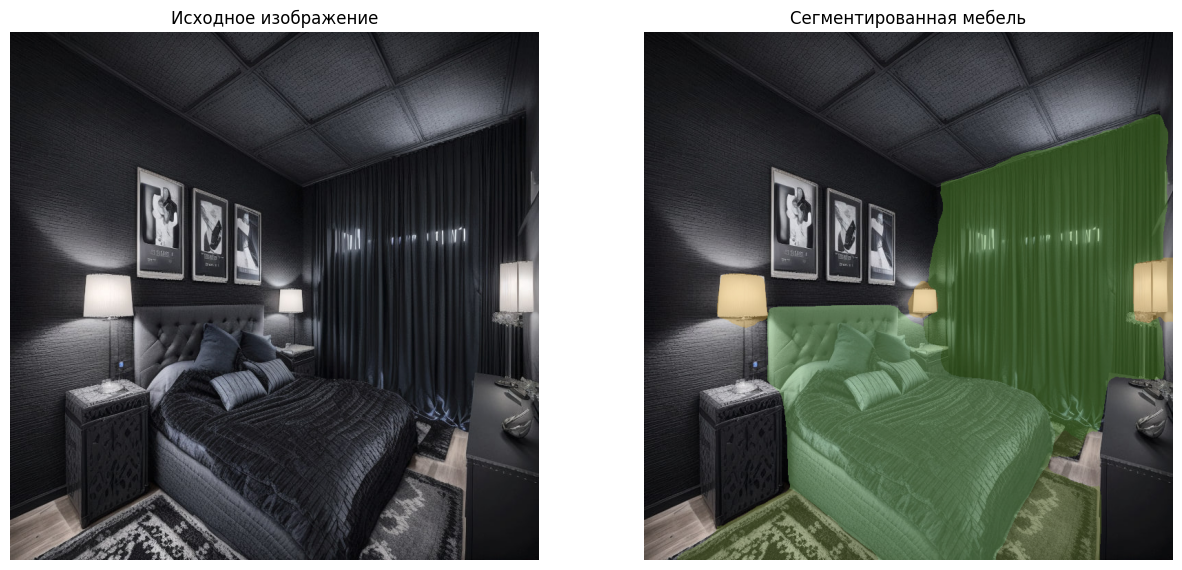

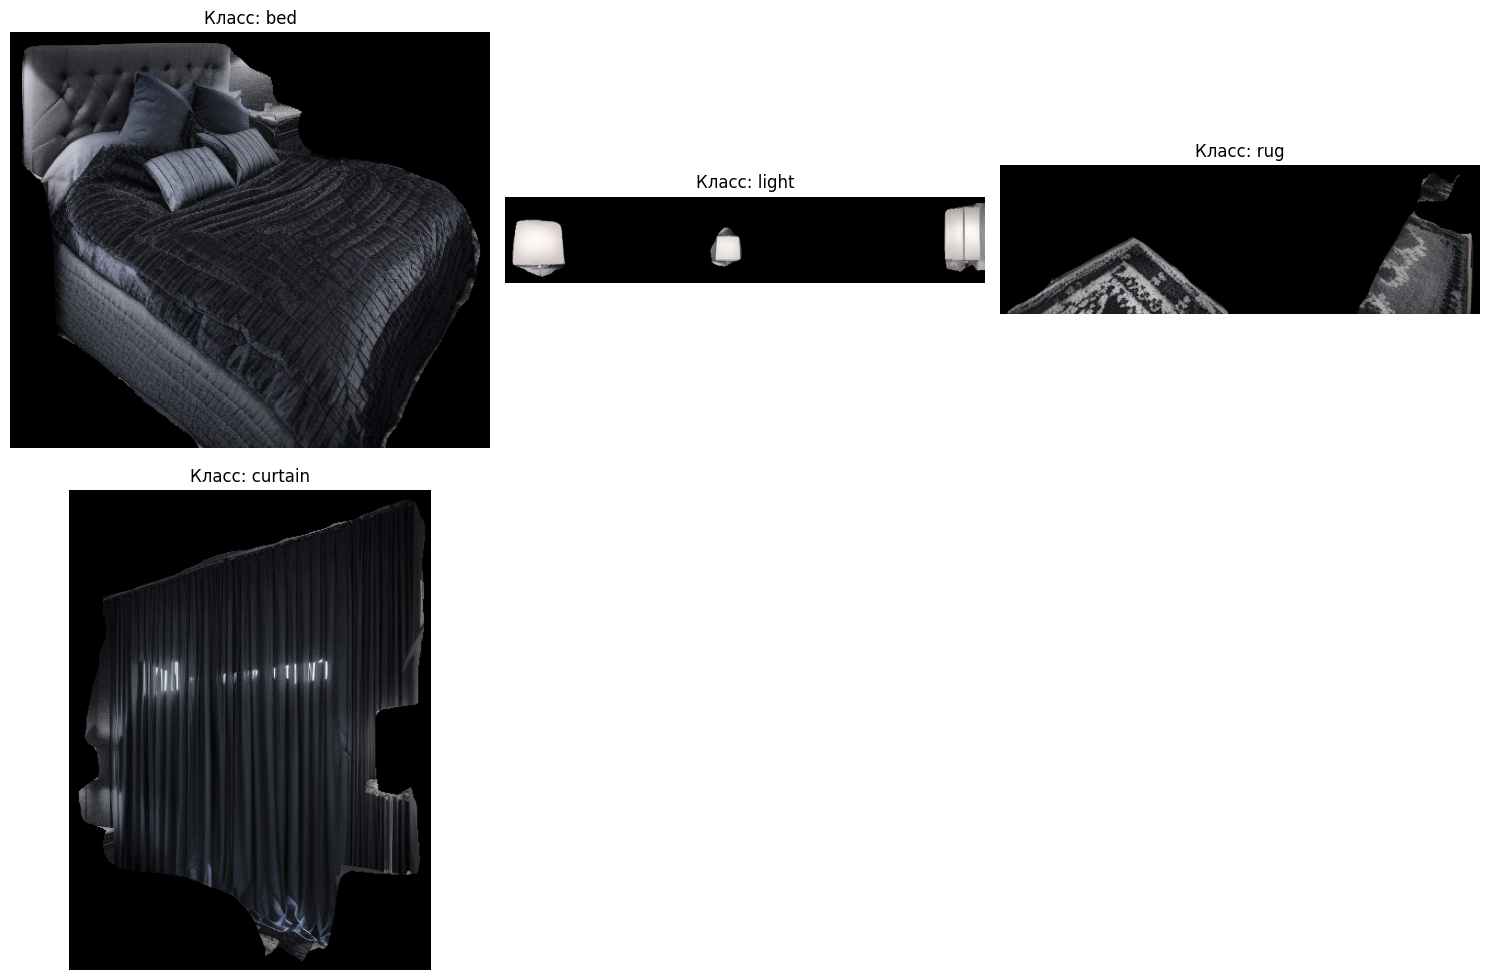

Сохранено: ./segmented_furniture/bed_0.png
Сохранено: ./segmented_furniture/light_1.png
Сохранено: ./segmented_furniture/rug_2.png
Сохранено: ./segmented_furniture/curtain_3.png
Сохранено полное сегментированное изображение: ./segmented_furniture/full_segmentation.jpg
Сохранена маска: ./segmented_furniture/bed_0_mask.png
Сохранена маска: ./segmented_furniture/light_1_mask.png
Сохранена маска: ./segmented_furniture/rug_2_mask.png
Сохранена маска: ./segmented_furniture/curtain_3_mask.png
Найдено предметов мебели: 4
- bed: площадь 110778 пикселей
- light: площадь 11609 пикселей
- rug: площадь 32207 пикселей
- curtain: площадь 115245 пикселей


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
import cv2
from matplotlib.patches import Rectangle
import random

# Функция для генерации случайных цветов для каждого класса
def generate_random_colors(n):
    colors = []
    for i in range(n):
        color = (random.random(), random.random(), random.random())
        colors.append(color)
    return colors

# Классы COCO, связанные с мебелью (индекс и соответствующее название)
# Это подмножество классов из COCO dataset
FURNITURE_CLASSES = {
    # Основная мебель
    56: "chair",          # стул
    57: "couch",          # диван
    59: "bed",            # кровать
    60: "dining table",   # обеденный стол
    61: "toilet",         # унитаз
    62: "tv",             # телевизор
    68: "microwave",      # микроволновка
    69: "oven",           # духовка
    70: "toaster",        # тостер
    72: "refrigerator",   # холодильник
    74: "clock",          # часы
    75: "vase",           # ваза
    85: "curtain",        # штора 
    95: "pillow",         # подушка 
    92: "light",          # лампа/источник света 
    132: "rug",           # ковер 
    93: "mirror",         # зеркало 
    104: "shelf",         # полка 
    84: "counter",        # стойка 
}


def segment_furniture(image_path, confidence_threshold=0.7):
    """
    Сегментация мебели на изображении с использованием Mask2Former
    
    Args:
        image_path: путь к файлу или URL изображения
        confidence_threshold: порог уверенности для отображения результатов
        
    Returns:
        tuple: (image, segmented_objects, class_ids, class_names, masks)
    """
    # Загрузка модели и процессора
    processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-coco-panoptic")
    model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-coco-panoptic")
    
    # Загрузка изображения
    if image_path.startswith(('http://', 'https://')):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content))
    else:
        image = Image.open(image_path)
    
    # Убедитесь, что изображение в формате RGB
    if image.mode != 'RGB':
        image = image.convert('RGB')
        print(f"Изображение преобразовано в RGB")
    
    # Преобразование изображения и получение предсказаний
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Постобработка результатов
    result = processor.post_process_panoptic_segmentation(
        outputs, 
        target_sizes=[image.size[::-1]],
        threshold=confidence_threshold,
    )[0]
    
    # Извлечение нужной информации
    segmentation = result["segmentation"]
    segments_info = result["segments_info"]
    
    # Фильтрация только объектов мебели
    furniture_segments = []
    furniture_masks = []
    furniture_class_ids = []
    furniture_class_names = []
    
    for segment in segments_info:
        class_id = segment["label_id"]
        # Проверяем, является ли объект мебелью
        if class_id in FURNITURE_CLASSES:
            furniture_segments.append(segment)
            furniture_class_ids.append(class_id)
            furniture_class_names.append(FURNITURE_CLASSES[class_id])
            
            # Создаем маску для этого объекта
            mask = (segmentation == segment["id"]).cpu().numpy()
            furniture_masks.append(mask)
    
    # Конвертирование изображения в массив numpy для обработки
    image_np = np.array(image)
    
    return image_np, furniture_segments, furniture_class_ids, furniture_class_names, furniture_masks

def visualize_segmentation(image, segments, class_ids, class_names, masks):
    """
    Визуализация результатов сегментации с использованием matplotlib
    
    Args:
        image: исходное изображение в формате numpy array
        segments: информация о сегментах
        class_ids: идентификаторы классов
        class_names: названия классов
        masks: маски для каждого объекта
    """
    # Генерация случайных цветов для каждого класса
    colors = generate_random_colors(len(class_ids))
    
    # Отображение исходного изображения
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Исходное изображение")
    plt.axis('off')
    
    # Создание и отображение изображения с масками
    masked_image = image.copy()
    for i, mask in enumerate(masks):
        # Применяем цветную маску с прозрачностью
        color_mask = np.zeros_like(image)
        color = [int(c * 255) for c in colors[i]]
        for c in range(3):
            color_mask[:, :, c] = color[c]
        
        # Применяем маску с легкой прозрачностью
        alpha = 0.4  # Уровень прозрачности
        mask_area = mask.astype(bool)
        masked_image[mask_area] = masked_image[mask_area] * (1 - alpha) + color_mask[mask_area] * alpha
    
    # Отображение изображения с масками
    plt.subplot(1, 2, 2)
    plt.imshow(masked_image)
    plt.title("Сегментированная мебель")
    plt.axis('off')
    
    # Второй график для отображения отдельных объектов с их классами
    num_objects = len(class_ids)
    if num_objects > 0:
        # Определяем количество строк и столбцов для подграфиков
        cols = min(3, num_objects)
        rows = (num_objects + cols - 1) // cols
        
        plt.figure(figsize=(15, 5 * rows))
        
        for i, (mask, class_name) in enumerate(zip(masks, class_names)):
            plt.subplot(rows, cols, i + 1)
            
            # Вырезаем объект с помощью маски
            object_image = image.copy()
            # Создаем черный фон
            bg = np.zeros_like(object_image)
            # Копируем объект на черный фон
            bg[mask] = object_image[mask]
            
            # Обрезаем изображение до размеров объекта
            # Находим границы маски
            y_indices, x_indices = np.where(mask)
            if len(y_indices) > 0 and len(x_indices) > 0:
                x_min, x_max = np.min(x_indices), np.max(x_indices)
                y_min, y_max = np.min(y_indices), np.max(y_indices)
                
                # Добавляем небольшой отступ
                padding = 10
                x_min = max(0, x_min - padding)
                y_min = max(0, y_min - padding)
                x_max = min(bg.shape[1] - 1, x_max + padding)
                y_max = min(bg.shape[0] - 1, y_max + padding)
                
                # Обрезаем изображение
                cropped_object = bg[y_min:y_max, x_min:x_max]
                
                plt.imshow(cropped_object)
                plt.title(f"Класс: {class_name}")
                plt.axis('off')
            else:
                plt.text(0.5, 0.5, "Пустая маска", horizontalalignment='center')
    
    plt.tight_layout()
    plt.show()

def save_segmented_objects(image, masks, class_names, output_dir="./segmented_furniture"):
    """
    Сохранение сегментированных объектов как отдельных файлов
    
    Args:
        image: исходное изображение в формате numpy array
        masks: маски для каждого объекта
        class_names: названия классов
        output_dir: директория для сохранения результатов
    """
    import os
    
    # Создаем директорию, если она не существует
    os.makedirs(output_dir, exist_ok=True)
    
    for i, (mask, class_name) in enumerate(zip(masks, class_names)):
        # Вырезаем объект с помощью маски
        object_image = image.copy()
        # Создаем прозрачный фон (RGBA)
        bg = np.zeros((object_image.shape[0], object_image.shape[1], 4), dtype=np.uint8)
        # Копируем RGB каналы объекта
        bg[mask, :3] = object_image[mask]
        # Устанавливаем альфа канал (прозрачность)
        bg[mask, 3] = 255  # Непрозрачно для объекта
        
        # Обрезаем изображение до размеров объекта
        y_indices, x_indices = np.where(mask)
        if len(y_indices) > 0 and len(x_indices) > 0:
            x_min, x_max = np.min(x_indices), np.max(x_indices)
            y_min, y_max = np.min(y_indices), np.max(y_indices)
            
            # Добавляем небольшой отступ
            padding = 10
            x_min = max(0, x_min - padding)
            y_min = max(0, y_min - padding)
            x_max = min(bg.shape[1] - 1, x_max + padding)
            y_max = min(bg.shape[0] - 1, y_max + padding)
            
            # Обрезаем изображение
            cropped_object = bg[y_min:y_max, x_min:x_max]
            
            # Сохраняем изображение с прозрачным фоном
            filename = f"{output_dir}/{class_name}_{i}.png"
            Image.fromarray(cropped_object).save(filename)
            print(f"Сохранено: {filename}")
        else:
            print(f"Пропуск пустой маски для {class_name}_{i}")

    # Сохраняем также полное сегментированное изображение
    colors = generate_random_colors(len(masks))
    masked_image = image.copy()
    
    for i, mask in enumerate(masks):
        color = [int(c * 255) for c in colors[i]]
        alpha = 0.4
        mask_area = mask.astype(bool)
        for c in range(3):
            masked_image[mask_area, c] = masked_image[mask_area, c] * (1 - alpha) + color[c] * alpha
    
    # Добавляем аннотации с названиями классов
    for i, (mask, class_name) in enumerate(zip(masks, class_names)):
        y_indices, x_indices = np.where(mask)
        if len(y_indices) > 0:
            y_min = np.min(y_indices)
            x_center = np.mean(x_indices).astype(int)
            
            # Добавляем текст с названием класса
            cv2.putText(masked_image, class_name, (x_center, y_min - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    # Сохраняем полное сегментированное изображение
    full_segmented_path = f"{output_dir}/full_segmentation.jpg"
    Image.fromarray(masked_image).save(full_segmented_path)
    print(f"Сохранено полное сегментированное изображение: {full_segmented_path}")
    
    # Сохраняем маски отдельно для будущего использования в inpainting
    for i, (mask, class_name) in enumerate(zip(masks, class_names)):
        mask_image = mask.astype(np.uint8) * 255
        mask_path = f"{output_dir}/{class_name}_{i}_mask.png"
        Image.fromarray(mask_image).save(mask_path)
        print(f"Сохранена маска: {mask_path}")

# Пример использования
def main():
    # URL или путь к изображению
    image_path = "test4.jpg"  # Замените на ваш путь или URL
    
    # Сегментация мебели
    image, segments, class_ids, class_names, masks = segment_furniture(image_path)
    
    # Визуализация результатов
    visualize_segmentation(image, segments, class_ids, class_names, masks)
    
    # Сохранение сегментированных объектов
    save_segmented_objects(image, masks, class_names)
    
    # Вывод статистики
    print(f"Найдено предметов мебели: {len(class_names)}")
    for i, name in enumerate(class_names):
        area = masks[i].sum()
        print(f"- {name}: площадь {area} пикселей")

if __name__ == "__main__":
    main()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
c:\Interior\.venv\lib\site-packages\transformers\utils\deprecation.py:172: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)
`label_ids_to_fuse` unset. No instance will be fused.


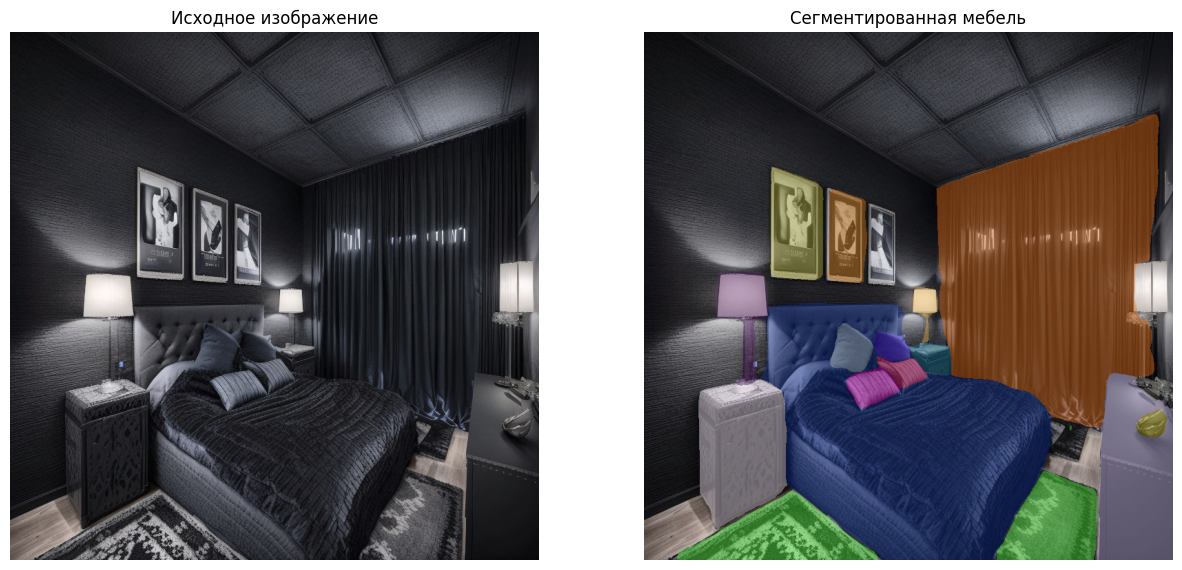

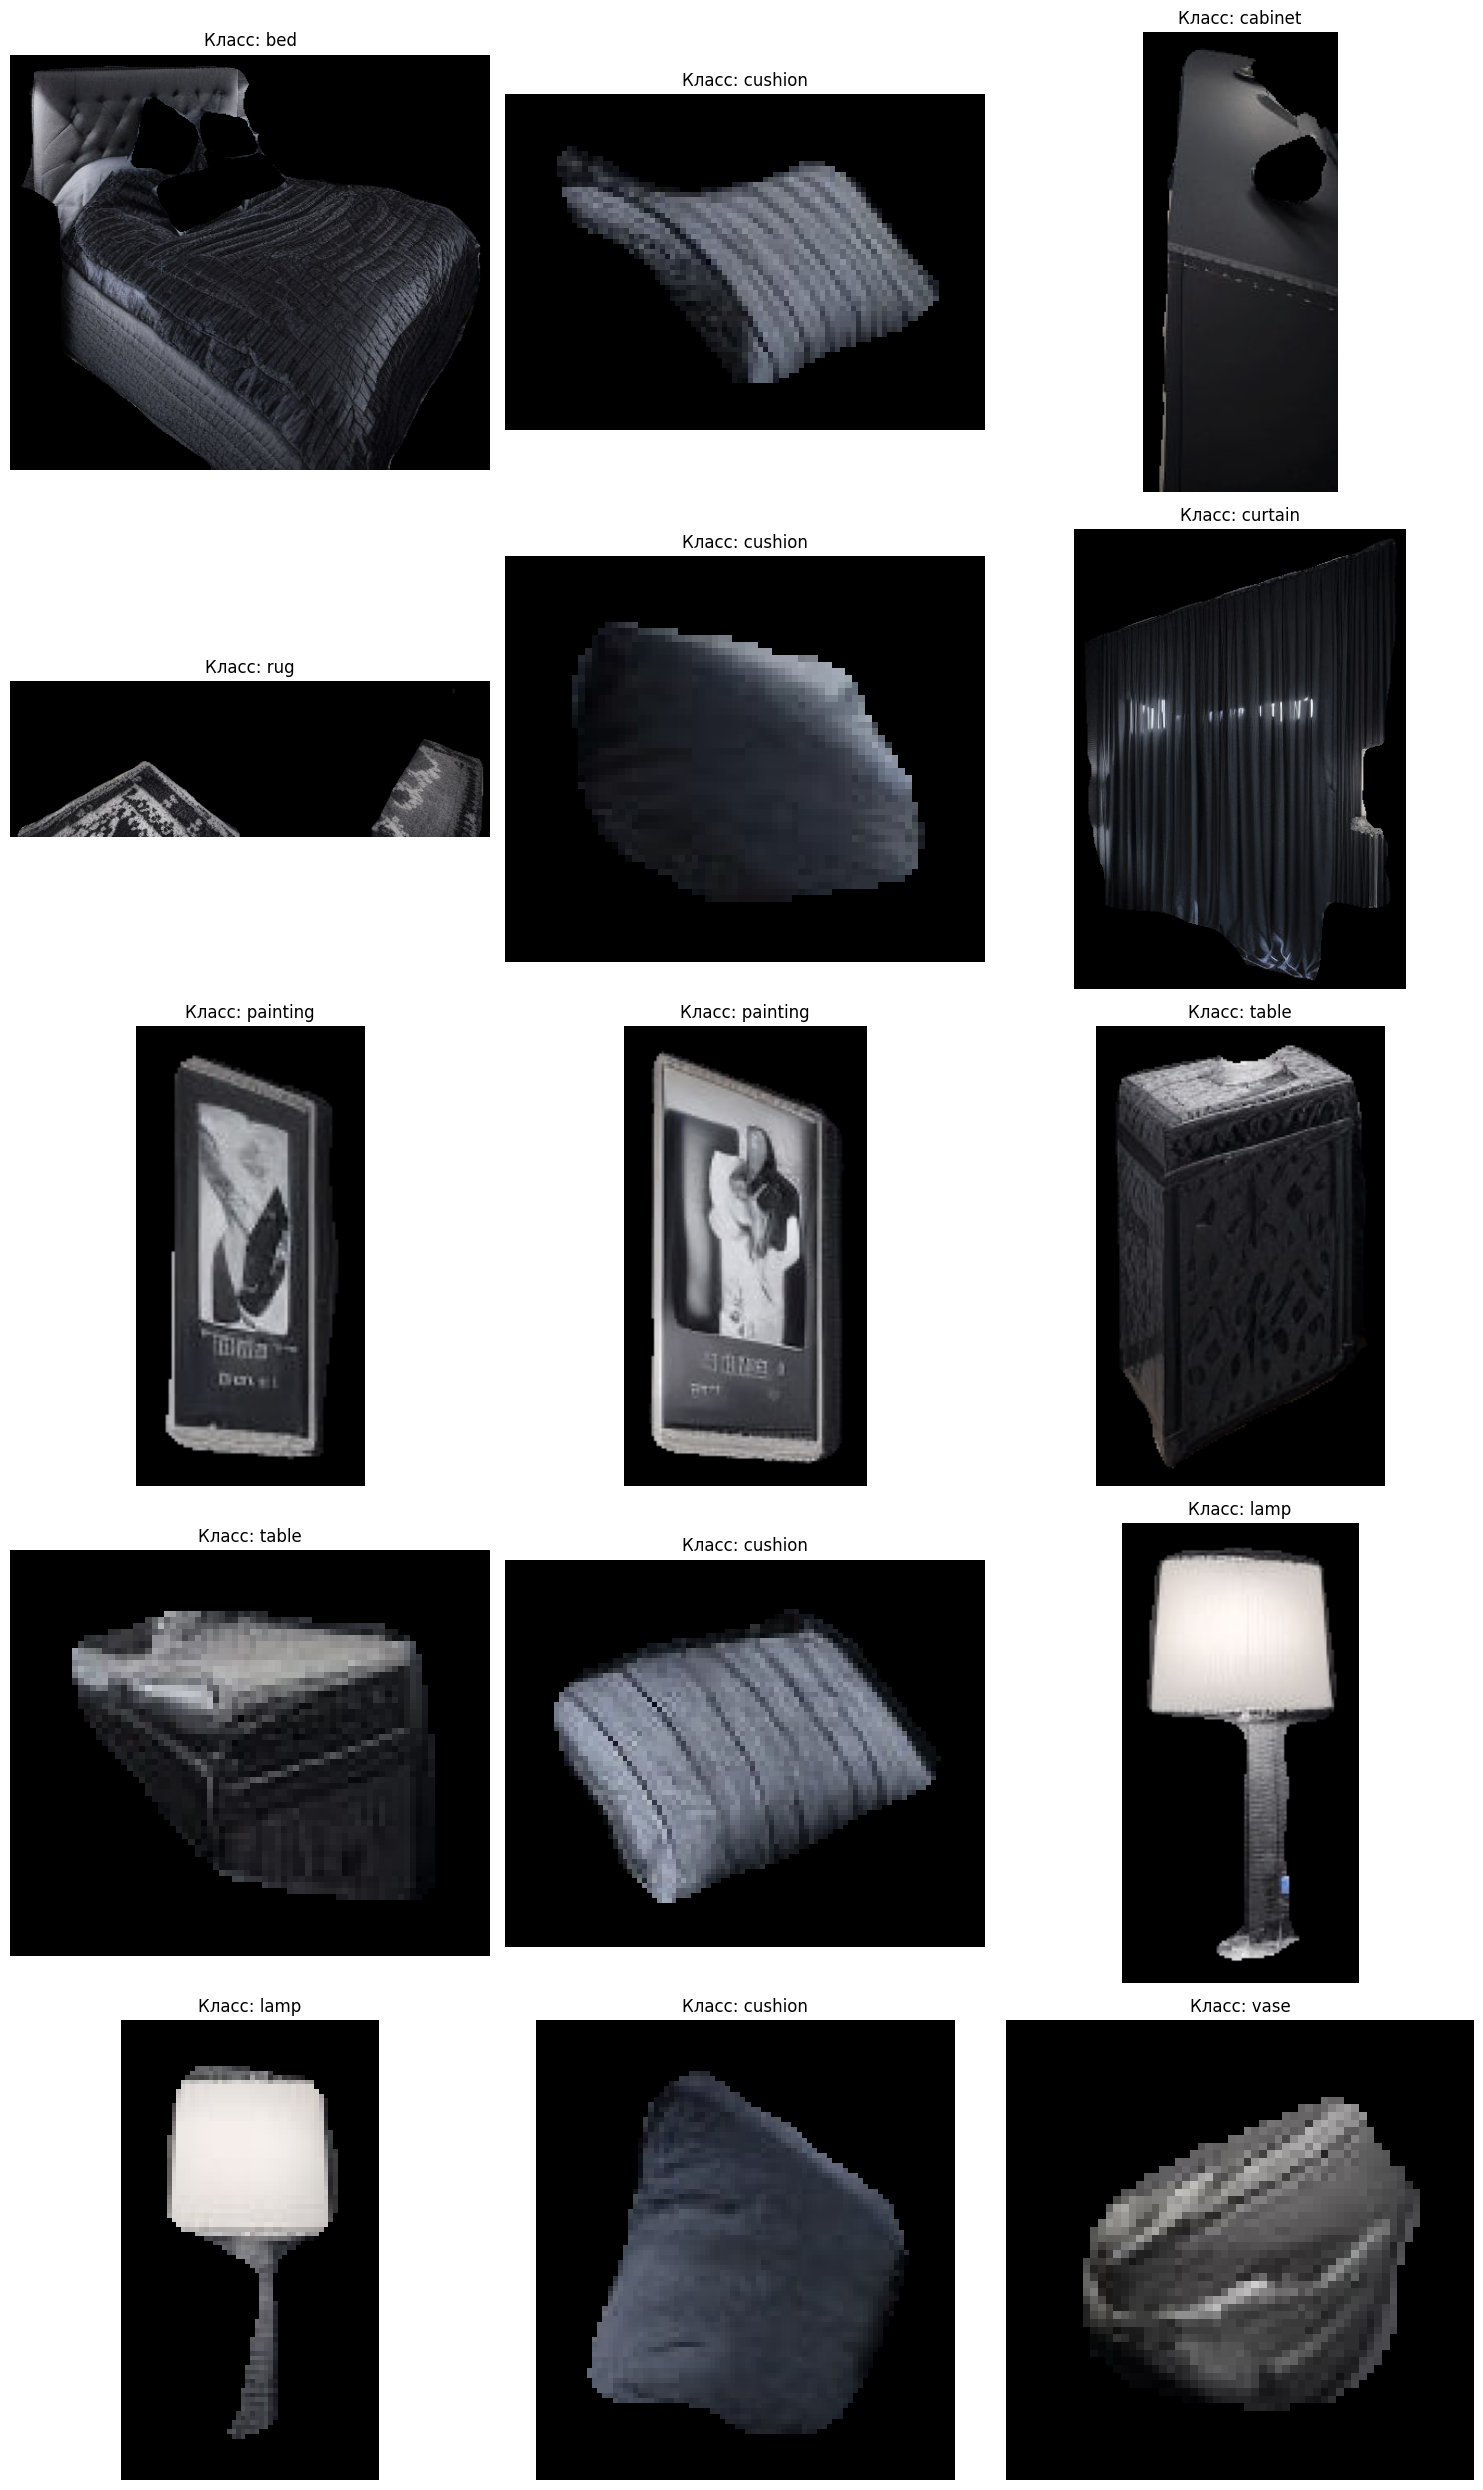

Сохранено: ./segmented_furniture/bed_0.png
Сохранено: ./segmented_furniture/cushion_1.png
Сохранено: ./segmented_furniture/cabinet_2.png
Сохранено: ./segmented_furniture/rug_3.png
Сохранено: ./segmented_furniture/cushion_4.png
Сохранено: ./segmented_furniture/curtain_5.png
Сохранено: ./segmented_furniture/painting_6.png
Сохранено: ./segmented_furniture/painting_7.png
Сохранено: ./segmented_furniture/table_8.png
Сохранено: ./segmented_furniture/table_9.png
Сохранено: ./segmented_furniture/cushion_10.png
Сохранено: ./segmented_furniture/lamp_11.png
Сохранено: ./segmented_furniture/lamp_12.png
Сохранено: ./segmented_furniture/cushion_13.png
Сохранено: ./segmented_furniture/vase_14.png
Сохранено полное сегментированное изображение: ./segmented_furniture/full_segmentation.jpg
Сохранена маска: ./segmented_furniture/bed_0_mask.png
Сохранена маска: ./segmented_furniture/cushion_1_mask.png
Сохранена маска: ./segmented_furniture/cabinet_2_mask.png
Сохранена маска: ./segmented_furniture/rug_3_mas

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
import cv2
from matplotlib.patches import Rectangle
import random

# Функция для генерации случайных цветов для каждого класса
def generate_random_colors(n):
    colors = []
    for i in range(n):
        color = (random.random(), random.random(), random.random())
        colors.append(color)
    return colors

FURNITURE_CLASSES = {
    # Основная мебель
    7: "bed",               # кровать
    10: "cabinet",          # шкаф (кухонный/офисный)
    15: "table",            # стол (общий)
    19: "chair",            # стул
    23: "sofa",             # диван
    30: "armchair",         # кресло
    33: "desk",             # письменный стол
    35: "wardrobe",         # гардероб
    44: "chest of drawers", # комод
    64: "coffee table",     # журнальный столик
    110: "stool",           # табурет
    
    # Сантехника и кухня
    37: "bathtub",          # ванна
    47: "sink",             # раковина
    50: "refrigerator",     # холодильник
    65: "toilet",           # унитаз
    71: "stove",            # плита
    118: "oven",            # духовка
    124: "microwave",       # микроволновка
    
    # Декор и текстиль
    18: "curtain",          # штора
    22: "painting",         # картина
    27: "mirror",           # зеркало
    28: "rug",              # ковер
    39: "cushion",          # подушка (декоративная)
    57: "pillow",           # подушка (спальная)
    85: "chandelier",       # люстра
    97: "ottoman",          # пуфик
    135: "vase",            # ваза
    
    # Хранение и полки
    24: "shelf",            # полка
    62: "bookcase",         # книжный шкаф
    
    # Освещение
    36: "lamp",             # лампа (настольная/торшер)
    82: "light",            # источник света
    134: "sconce",          # настенный светильник
    
    # Дополнительные элементы
    49: "fireplace",        # камин
    70: "countertop",       # столешница
    73: "kitchen island",   # кухонный остров
    99: "buffet",           # сервант
    146: "radiator",        # радиатор отопления
    148: "clock",           # часы
}

def segment_furniture(image_path, confidence_threshold=0.7):
    """
    Сегментация мебели на изображении с использованием Mask2Former
    
    Args:
        image_path: путь к файлу или URL изображения
        confidence_threshold: порог уверенности для отображения результатов
        
    Returns:
        tuple: (image, segmented_objects, class_ids, class_names, masks)
    """
    # Загрузка модели и процессора
    processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-ade-panoptic")
    model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-ade-panoptic")
    
    # Загрузка изображения
    if image_path.startswith(('http://', 'https://')):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content))
    else:
        image = Image.open(image_path)
    
    # Убедитесь, что изображение в формате RGB
    if image.mode != 'RGB':
        image = image.convert('RGB')
        print(f"Изображение преобразовано в RGB")
    
    # Преобразование изображения и получение предсказаний
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Постобработка результатов
    result = processor.post_process_panoptic_segmentation(
        outputs, 
        target_sizes=[image.size[::-1]],
        threshold=confidence_threshold,
    )[0]
    
    # Извлечение нужной информации
    segmentation = result["segmentation"]
    segments_info = result["segments_info"]
    
    # Фильтрация только объектов мебели
    furniture_segments = []
    furniture_masks = []
    furniture_class_ids = []
    furniture_class_names = []
    
    for segment in segments_info:
        class_id = segment["label_id"]
        # Проверяем, является ли объект мебелью
        if class_id in FURNITURE_CLASSES:
            furniture_segments.append(segment)
            furniture_class_ids.append(class_id)
            furniture_class_names.append(FURNITURE_CLASSES[class_id])
            
            # Создаем маску для этого объекта
            mask = (segmentation == segment["id"]).cpu().numpy()
            furniture_masks.append(mask)
    
    # Конвертирование изображения в массив numpy для обработки
    image_np = np.array(image)
    
    return image_np, furniture_segments, furniture_class_ids, furniture_class_names, furniture_masks

def visualize_segmentation(image, segments, class_ids, class_names, masks):
    """
    Визуализация результатов сегментации с использованием matplotlib
    
    Args:
        image: исходное изображение в формате numpy array
        segments: информация о сегментах
        class_ids: идентификаторы классов
        class_names: названия классов
        masks: маски для каждого объекта
    """
    # Генерация случайных цветов для каждого класса
    colors = generate_random_colors(len(class_ids))
    
    # Отображение исходного изображения
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Исходное изображение")
    plt.axis('off')
    
    # Создание и отображение изображения с масками
    masked_image = image.copy()
    for i, mask in enumerate(masks):
        # Применяем цветную маску с прозрачностью
        color_mask = np.zeros_like(image)
        color = [int(c * 255) for c in colors[i]]
        for c in range(3):
            color_mask[:, :, c] = color[c]
        
        # Применяем маску с легкой прозрачностью
        alpha = 0.4  # Уровень прозрачности
        mask_area = mask.astype(bool)
        masked_image[mask_area] = masked_image[mask_area] * (1 - alpha) + color_mask[mask_area] * alpha
    
    # Отображение изображения с масками
    plt.subplot(1, 2, 2)
    plt.imshow(masked_image)
    plt.title("Сегментированная мебель")
    plt.axis('off')
    
    # Второй график для отображения отдельных объектов с их классами
    num_objects = len(class_ids)
    if num_objects > 0:
        # Определяем количество строк и столбцов для подграфиков
        cols = min(3, num_objects)
        rows = (num_objects + cols - 1) // cols
        
        plt.figure(figsize=(15, 5 * rows))
        
        for i, (mask, class_name) in enumerate(zip(masks, class_names)):
            plt.subplot(rows, cols, i + 1)
            
            # Вырезаем объект с помощью маски
            object_image = image.copy()
            # Создаем черный фон
            bg = np.zeros_like(object_image)
            # Копируем объект на черный фон
            bg[mask] = object_image[mask]
            
            # Обрезаем изображение до размеров объекта
            # Находим границы маски
            y_indices, x_indices = np.where(mask)
            if len(y_indices) > 0 and len(x_indices) > 0:
                x_min, x_max = np.min(x_indices), np.max(x_indices)
                y_min, y_max = np.min(y_indices), np.max(y_indices)
                
                # Добавляем небольшой отступ
                padding = 10
                x_min = max(0, x_min - padding)
                y_min = max(0, y_min - padding)
                x_max = min(bg.shape[1] - 1, x_max + padding)
                y_max = min(bg.shape[0] - 1, y_max + padding)
                
                # Обрезаем изображение
                cropped_object = bg[y_min:y_max, x_min:x_max]
                
                plt.imshow(cropped_object)
                plt.title(f"Класс: {class_name}")
                plt.axis('off')
            else:
                plt.text(0.5, 0.5, "Пустая маска", horizontalalignment='center')
    
    plt.tight_layout()
    plt.show()

def save_segmented_objects(image, masks, class_names, output_dir="./segmented_furniture"):
    """
    Сохранение сегментированных объектов как отдельных файлов
    
    Args:
        image: исходное изображение в формате numpy array
        masks: маски для каждого объекта
        class_names: названия классов
        output_dir: директория для сохранения результатов
    """
    import os
    
    # Создаем директорию, если она не существует
    os.makedirs(output_dir, exist_ok=True)
    
    for i, (mask, class_name) in enumerate(zip(masks, class_names)):
        # Вырезаем объект с помощью маски
        object_image = image.copy()
        # Создаем прозрачный фон (RGBA)
        bg = np.zeros((object_image.shape[0], object_image.shape[1], 4), dtype=np.uint8)
        # Копируем RGB каналы объекта
        bg[mask, :3] = object_image[mask]
        # Устанавливаем альфа канал (прозрачность)
        bg[mask, 3] = 255  # Непрозрачно для объекта
        
        # Обрезаем изображение до размеров объекта
        y_indices, x_indices = np.where(mask)
        if len(y_indices) > 0 and len(x_indices) > 0:
            x_min, x_max = np.min(x_indices), np.max(x_indices)
            y_min, y_max = np.min(y_indices), np.max(y_indices)
            
            # Добавляем небольшой отступ
            padding = 10
            x_min = max(0, x_min - padding)
            y_min = max(0, y_min - padding)
            x_max = min(bg.shape[1] - 1, x_max + padding)
            y_max = min(bg.shape[0] - 1, y_max + padding)
            
            # Обрезаем изображение
            cropped_object = bg[y_min:y_max, x_min:x_max]
            
            # Сохраняем изображение с прозрачным фоном
            filename = f"{output_dir}/{class_name}_{i}.png"
            Image.fromarray(cropped_object).save(filename)
            print(f"Сохранено: {filename}")
        else:
            print(f"Пропуск пустой маски для {class_name}_{i}")

    # Сохраняем также полное сегментированное изображение
    colors = generate_random_colors(len(masks))
    masked_image = image.copy()
    
    for i, mask in enumerate(masks):
        color = [int(c * 255) for c in colors[i]]
        alpha = 0.4
        mask_area = mask.astype(bool)
        for c in range(3):
            masked_image[mask_area, c] = masked_image[mask_area, c] * (1 - alpha) + color[c] * alpha
    
    # Добавляем аннотации с названиями классов
    for i, (mask, class_name) in enumerate(zip(masks, class_names)):
        y_indices, x_indices = np.where(mask)
        if len(y_indices) > 0:
            y_min = np.min(y_indices)
            x_center = np.mean(x_indices).astype(int)
            
            # Добавляем текст с названием класса
            cv2.putText(masked_image, class_name, (x_center, y_min - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    # Сохраняем полное сегментированное изображение
    full_segmented_path = f"{output_dir}/full_segmentation.jpg"
    Image.fromarray(masked_image).save(full_segmented_path)
    print(f"Сохранено полное сегментированное изображение: {full_segmented_path}")
    
    # Сохраняем маски отдельно для будущего использования в inpainting
    for i, (mask, class_name) in enumerate(zip(masks, class_names)):
        mask_image = mask.astype(np.uint8) * 255
        mask_path = f"{output_dir}/{class_name}_{i}_mask.png"
        Image.fromarray(mask_image).save(mask_path)
        print(f"Сохранена маска: {mask_path}")

# Пример использования
def main():
    # URL или путь к изображению
    image_path = "test4.jpg"  # Замените на ваш путь или URL
    
    # Сегментация мебели
    image, segments, class_ids, class_names, masks = segment_furniture(image_path)
    
    # Визуализация результатов
    visualize_segmentation(image, segments, class_ids, class_names, masks)
    
    # Сохранение сегментированных объектов
    save_segmented_objects(image, masks, class_names)
    
    # Вывод статистики
    print(f"Найдено предметов мебели: {len(class_names)}")
    for i, name in enumerate(class_names):
        area = masks[i].sum()
        print(f"- {name}: площадь {area} пикселей")

if __name__ == "__main__":
    main()

Нахождение bed на изображении комнаты...


c:\Interior\.venv\lib\site-packages\transformers\utils\deprecation.py:172: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)
`label_ids_to_fuse` unset. No instance will be fused.


Маска сохранена: ./replaced_furniture/bed_mask.png
Извлечение мебели с изображения продукта...
Изображение преобразовано в RGB


`label_ids_to_fuse` unset. No instance will be fused.


Применение Stable Diffusion Inpainting...
Изображение преобразовано в RGB


`label_ids_to_fuse` unset. No instance will be fused.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (168 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['ter is thick and plush , draped neatly over the bed , with a striped pattern in shades of gray , black , and subtle brown , creating a horizontal gradient effect . the lighting emphasizes the soft texture of the fabric , casting natural shadows on the left side and under the bed , enhancing its cozy and luxurious look . the bed has no visible legs , giving it a floating appearance , and there is a small nightstand partially visible on the back right side']


  0%|          | 0/50 [00:00<?, ?it/s]

Результат сохранен: ./replaced_furniture/replaced_bed_sd_inpainting.jpg


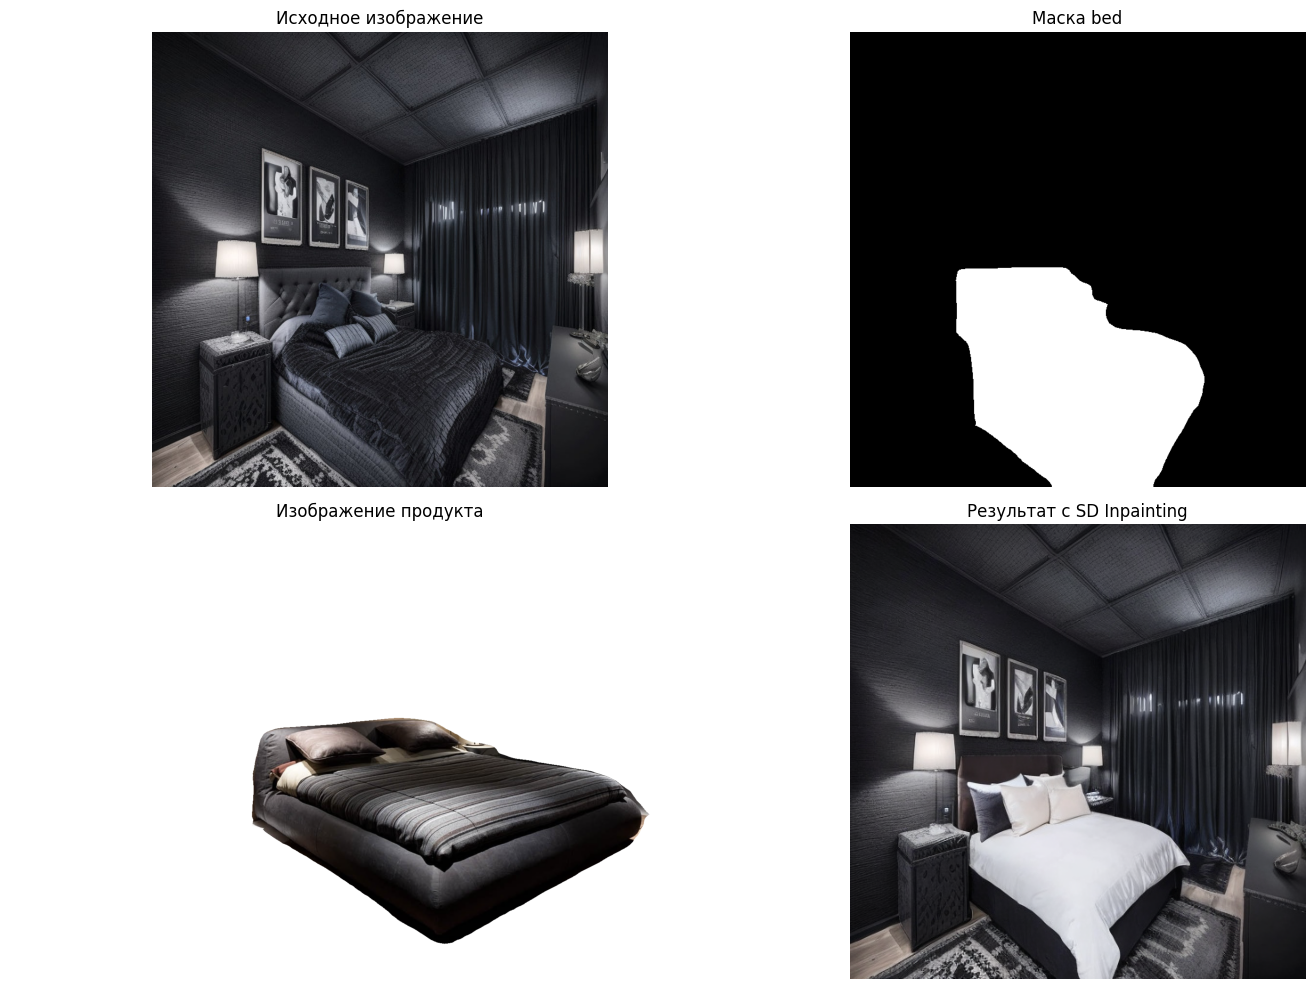

Готово!


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import requests
from io import BytesIO
import os
# from segment_furniture import segment_furniture, visualize_segmentation
from diffusers import StableDiffusionInpaintPipeline

def find_furniture_mask(image_path, target_class="bed"):
    """
    Находит предмет мебели указанного класса на изображении и возвращает его маску
    
    Args:
        image_path: путь к изображению комнаты
        target_class: класс мебели для поиска
        
    Returns:
        tuple: (изображение, маска предмета, bbox, имя класса)
    """
    # Используем существующую функцию segment_furniture для сегментации мебели
    image, segments, class_ids, class_names, masks = segment_furniture(image_path)
    
    # Ищем маску для нужного класса мебели
    furniture_mask = None
    furniture_name = None
    
    for i, name in enumerate(class_names):
        if name.lower() == target_class.lower():
            furniture_mask = masks[i]
            furniture_name = name
            break
    
    if furniture_mask is None:
        raise ValueError(f"Не удалось найти {target_class} на изображении комнаты")
    
    # Находим ограничивающий прямоугольник для маски
    y_indices, x_indices = np.where(furniture_mask)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    
    bbox = [x_min, y_min, x_max, y_max]
    return image, furniture_mask, bbox, furniture_name

def prepare_inpainting_mask(mask, dilation_kernel_size=15):
    """
    Подготавливает маску для инпейнтинга, возможно расширяя ее для лучших результатов
    
    Args:
        mask: бинарная маска объекта
        dilation_kernel_size: размер ядра для расширения маски
    
    Returns:
        inpainting_mask: маска для инпейнтинга в формате PIL.Image
    """
    # Расширяем маску для лучших результатов инпейнтинга
    kernel = np.ones((dilation_kernel_size, dilation_kernel_size), np.uint8)
    dilated_mask = cv2.dilate(mask.astype(np.uint8), kernel, iterations=1)
    
    # Преобразуем в формат PIL для Stable Diffusion (белые пиксели означают области для инпейнтинга)
    inpainting_mask_pil = Image.fromarray(dilated_mask * 255)
    
    return inpainting_mask_pil

def replace_with_sd_inpainting(image, mask, prompt, negative_prompt=None):
    """
    Заменяет объект на изображении с использованием Stable Diffusion Inpainting
    
    Args:
        image: исходное изображение (numpy array)
        mask: маска объекта для замены (бинарная, где 1 означает пиксели для замены)
        prompt: текстовый запрос, описывающий что должно быть на месте объекта
        negative_prompt: отрицательный запрос для улучшения генерации
        
    Returns:
        result_image: результат инпейнтинга
    """
    # Загружаем модель Stable Diffusion Inpainting
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        "stabilityai/stable-diffusion-2-inpainting",
        torch_dtype=torch.float16,
    )
    
    if torch.cuda.is_available():
        pipe = pipe.to("cuda")
    
    # Преобразуем numpy изображение в PIL
    image_pil = Image.fromarray(image)
    
    # Подготавливаем маску для инпейнтинга
    mask_pil = prepare_inpainting_mask(mask)
    
    # Если отрицательный запрос не указан, используем дефолтный
    if negative_prompt is None:
        negative_prompt = "low quality, blurry, distorted, unrealistic, bad proportions"
    
    # Запускаем инпейнтинг
    result = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image=image_pil,
        mask_image=mask_pil,
        num_inference_steps=50,
        guidance_scale=7.5,
    ).images[0]
    
    # Преобразуем результат обратно в numpy array
    result_np = np.array(result)
    
    return result_np

def extract_furniture_from_product_image(product_image_path, target_class="bed"):
    """
    Извлекает мебель с изображения продукта, удаляя фон
    
    Args:
        product_image_path: путь к изображению продукта
        target_class: класс мебели для сегментации
        
    Returns:
        furniture_image: изображение мебели без фона (RGBA)
    """
    # Загрузка изображения
    if product_image_path.startswith(('http://', 'https://')):
        response = requests.get(product_image_path)
        product_image = Image.open(BytesIO(response.content))
    else:
        product_image = Image.open(product_image_path)
    
    # Убедимся, что изображение в формате RGB
    if product_image.mode != 'RGB':
        product_image = product_image.convert('RGB')
    
    # Преобразуем в numpy array
    product_np = np.array(product_image)
    
    # Пробуем сегментировать с помощью существующей функции
    try:
        _, segments, class_ids, class_names, masks = segment_furniture(product_image_path)
        
        # Ищем маску для нужного класса мебели
        product_mask = None
        for i, name in enumerate(class_names):
            if name.lower() == target_class.lower():
                product_mask = masks[i]
                break
    except Exception as e:
        print(f"Ошибка при сегментации продукта: {e}")
        product_mask = None
    
    # Если не удалось найти маску, используем GrabCut
    if product_mask is None:
        print("Используем GrabCut для удаления фона.")
        
        # Создаём прямоугольную маску вокруг центра изображения
        mask = np.zeros(product_np.shape[:2], np.uint8)
        rect_size = 0.8  # Размер прямоугольника относительно изображения
        
        # Рассчитываем координаты прямоугольника
        h, w = product_np.shape[:2]
        rect_w = int(w * rect_size)
        rect_h = int(h * rect_size)
        rect_x = (w - rect_w) // 2
        rect_y = (h - rect_h) // 2
        rect = (rect_x, rect_y, rect_w, rect_h)
        
        # Подготовка для GrabCut
        bgd_model = np.zeros((1, 65), np.float64)
        fgd_model = np.zeros((1, 65), np.float64)
        
        # Применяем GrabCut
        cv2.grabCut(product_np, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)
        
        # Создаем маску, где явный и предполагаемый фон установлены в 0, все остальное в 1
        product_mask = np.where((mask == 2) | (mask == 0), 0, 1).astype('bool')
    
    # Создаем изображение с прозрачным фоном
    product_with_alpha = np.zeros((product_np.shape[0], product_np.shape[1], 4), dtype=np.uint8)
    product_with_alpha[..., :3] = product_np
    product_with_alpha[..., 3] = (product_mask * 255).astype(np.uint8)  # Альфа-канал
    
    # Преобразуем в PIL Image
    furniture_image = Image.fromarray(product_with_alpha, 'RGBA')
    
    return furniture_image, product_mask

def create_sd_prompts(furniture_name, product_image_path):
    """
    Создает запросы для Stable Diffusion Inpainting на основе класса мебели
    
    Args:
        furniture_name: название класса мебели
        product_image_path: путь к изображению продукта
        
    Returns:
        tuple: (prompt, negative_prompt)
    """
    # Базовый запрос на основе типа мебели
    if "bed" in furniture_name.lower():
        prompt = f"a realistic modern {furniture_name} in a bedroom, high-quality furniture, comfortable, detailed texture"
    elif "chair" in furniture_name.lower() or "sofa" in furniture_name.lower() or "armchair" in furniture_name.lower():
        prompt = f"a realistic modern {furniture_name} in a room, high-quality furniture, comfortable seating, detailed texture"
    elif "table" in furniture_name.lower() or "desk" in furniture_name.lower():
        prompt = f"a realistic modern {furniture_name} in a room, high-quality furniture, wooden texture, elegant design"
    else:
        prompt = f"a realistic modern {furniture_name} in a room, high-quality furniture, detailed texture"
    
    # Добавляем информацию из имени файла продукта (может содержать цвет, материал и т.д.)
    product_filename = os.path.basename(product_image_path)
    product_name = os.path.splitext(product_filename)[0]
    
    # Извлекаем потенциальные ключевые слова из имени файла
    keywords = product_name.replace('_', ' ').replace('-', ' ').split()
    color_keywords = ['white', 'black', 'brown', 'gray', 'grey', 'blue', 'red', 'green', 'yellow', 'wooden', 'metal', 'fabric']
    
    for keyword in keywords:
        if keyword.lower() in color_keywords:
            prompt += f", {keyword}"
    
    # Отрицательный запрос для избегания артефактов
    negative_prompt = "low quality, blurry, distorted, unrealistic, bad proportions, wrong perspective, deformed furniture"
    
    return prompt, negative_prompt

def integrate_product_using_sd_inpainting(scene_image, furniture_mask, furniture_name, product_image_path):
    """
    Интегрирует новый продукт в сцену с использованием Stable Diffusion Inpainting
    
    Args:
        scene_image: исходное изображение сцены (numpy array)
        furniture_mask: маска мебели для замены
        furniture_name: название класса мебели
        product_image_path: путь к изображению продукта
        
    Returns:
        result_image: результат интеграции
    """
    # Создаем запросы для SD Inpainting
    prompt, negative_prompt = create_sd_prompts(furniture_name, product_image_path)
    
    # Извлекаем мебель с изображения продукта
    product_furniture, product_mask = extract_furniture_from_product_image(product_image_path, furniture_name)
    
    # Создаем промежуточное изображение с использованием информации о продукте
    # Этот шаг можно расширить, чтобы включить информацию о цвете, текстуре и т.д. из продукта
    
    # Финальный inpainting с учетом специфики продукта
    prompt += f", similar to the reference image, maintain scene lighting and perspective"с
    
    result_image = replace_with_sd_inpainting(scene_image, furniture_mask, prompt, negative_prompt)
    
    return result_image

def main():
    # Пути к изображениям
    scene_image_path = "test4.jpg"  # Путь к изображению комнаты
    product_image_path = "bed.png"  # Путь к изображению продукта (кровати)
    output_dir = "./replaced_furniture"
    os.makedirs(output_dir, exist_ok=True)
    
    # Класс мебели для замены
    target_class = "bed"
    
    # Шаг 1: Находим маску мебели на сцене
    print(f"Нахождение {target_class} на изображении комнаты...")
    scene_image, furniture_mask, bbox, furniture_name = find_furniture_mask(scene_image_path, target_class)
    
    # Сохраняем маску для отладки
    mask_path = f"{output_dir}/{target_class}_mask.png"
    Image.fromarray(furniture_mask.astype(np.uint8) * 255).save(mask_path)
    print(f"Маска сохранена: {mask_path}")
    
    # Шаг 2: Извлекаем мебель с изображения продукта
    print(f"Извлечение мебели с изображения продукта...")
    product_furniture, product_mask = extract_furniture_from_product_image(product_image_path, target_class)
    product_furniture.save(f"{output_dir}/extracted_{target_class}.png")
    
    # Шаг 3: Используем Stable Diffusion Inpainting для замены мебели
    print("Применение Stable Diffusion Inpainting...")
    result_image = integrate_product_using_sd_inpainting(
        scene_image, furniture_mask, furniture_name, product_image_path
    )
    
    # Сохраняем результат
    output_path = f"{output_dir}/replaced_{target_class}_sd_inpainting.jpg"
    Image.fromarray(result_image).save(output_path)
    print(f"Результат сохранен: {output_path}")
    
    # Визуализация результатов
    plt.figure(figsize=(15, 10))
    
    # Оригинальное изображение
    plt.subplot(2, 2, 1)
    plt.imshow(scene_image)
    plt.title("Исходное изображение")
    plt.axis('off')
    
    # Маска мебели
    plt.subplot(2, 2, 2)
    plt.imshow(furniture_mask, cmap='gray')
    plt.title(f"Маска {furniture_name}")
    plt.axis('off')
    
    # Изображение продукта
    plt.subplot(2, 2, 3)
    plt.imshow(np.array(product_furniture))
    plt.title("Изображение продукта")
    plt.axis('off')
    
    # Результат замены
    plt.subplot(2, 2, 4)
    plt.imshow(result_image)
    plt.title("Результат с SD Inpainting")
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/replacement_process.jpg")
    plt.show()
    
    print("Готово!")

if __name__ == "__main__":
    main()

Рекомендашки

In [14]:
from transformers import Mask2FormerImageProcessor, Mask2FormerForUniversalSegmentation, CLIPProcessor, CLIPModel
from PIL import Image
import torch
import os
import numpy as np
import chromadb
from chromadb.config import Settings
import pandas as pd
# from your_segmentation_module import segment_furniture  # функции segment_furniture, etc.

COCO_CLASSES = {"bed", "chair", "couch", "dining table"}
ADE_CLASSES = {"cabinet", "lamp", "armchair", "table"}

COCO_MODEL_NAME = "facebook/mask2former-swin-large-coco-panoptic"
ADE_MODEL_NAME = "facebook/mask2former-swin-large-ade-panoptic"
CLIP_MODEL_NAME = "openai/clip-vit-base-patch32"



In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model = CLIPModel.from_pretrained(CLIP_MODEL_NAME).to(device)
clip_processor = CLIPProcessor.from_pretrained(CLIP_MODEL_NAME)

# храним обе модели
processors = {
    "COCO": Mask2FormerImageProcessor.from_pretrained(COCO_MODEL_NAME),
    "ADE": Mask2FormerImageProcessor.from_pretrained(ADE_MODEL_NAME),
}

models = {
    "COCO": Mask2FormerForUniversalSegmentation.from_pretrained(COCO_MODEL_NAME).to(device),
    "ADE": Mask2FormerForUniversalSegmentation.from_pretrained(ADE_MODEL_NAME).to(device),
}

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
c:\Interior\.venv\lib\site-packages\transformers\utils\deprecation.py:172: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)


In [7]:
df = pd.read_csv("dataset/data.csv", sep=";")
df.dropna(subset=["image", "id_furniture"], inplace=True)

df['image'] = df['image'].apply(lambda x: 'dataset/' + x.replace('\\', '/'))
df


id_furniture                          image  \
0              1     dataset/images/train_0.png   
1              1     dataset/images/train_1.png   
2              1     dataset/images/train_2.png   
3              2     dataset/images/train_3.png   
4              2     dataset/images/train_4.png   
5              2     dataset/images/train_5.png   
6              3    dataset/images/train_54.png   
7              3    dataset/images/train_55.png   
8              3    dataset/images/train_56.png   
9              4  dataset/images/train_1341.png   
10             4  dataset/images/train_1342.png   
11             4  dataset/images/train_1343.png   
12             5   dataset/images/train_353.png   
13             5   dataset/images/train_354.png   
14             5   dataset/images/train_355.png   
15             6   dataset/images/train_398.png   
16             6   dataset/images/train_399.png   
17             6   dataset/images/train_400.png   
18             7   dataset/images/train_508.png   
19             7   dataset/images/train_509.png   
20             7   dataset/images/train_510.png   
21             8      dataset/images/hoff_1.png   
22             9      dataset/images/hoff_2.png   
23            10      dataset/images/hoff_3.png   

                                                 name  \
0                                        Серое кресло   
1                                        Серое кресло   
2                                        Серое кресло   
3                                      Кожанное крсло   
4                                      Кожанное крсло   
5                                      Кожанное крсло   
6                                      Цветное кресло   
7                                      Цветное кресло   
8                                      Цветное кресло   
9                                        Жёлтое крсло   
10                                       Жёлтое крсло   
11                                       Жёлтое крсло   
12                             Чёрный небольшой диван   
13                             Чёрный небольшой диван   
14                             Чёрный небольшой диван   
15                              Белый небольшой диван   
16                              Белый небольшой диван   
17                              Белый небольшой диван   
18                        Маленький деревянный столик   
19                        Маленький деревянный столик   
20                        Маленький деревянный столик   
21  Кровать с подъёмным механизмом Victori цвет тё...   
22  Каркас кровати Глазго цвет таксония, металл бр...   
23  Кровать Хелен цвет дуб крафт золотой, серый гр...   

                                          description      type  price  \
0                                        без описания  armchair   1200   
1                                        без описания  armchair   1200   
2                                        без описания  armchair   1200   
3                                        без описания  armchair   1500   
4                                        без описания  armchair   1500   
5                                        без описания  armchair   1500   
6                                        без описания  armchair   2100   
7                                        без описания  armchair   2100   
8                                        без описания  armchair   2100   
9                                        без описания  armchair   3000   
10                                       без описания  armchair   3000   
11                                       без описания  armchair   3000   
12                                       без описания     couch  12000   
13                                       без описания     couch  12000   
14                                       без описания     couch  12000   
15                                       без описания     couch  12000   
16                                       без

In [10]:
import torch
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import os
import pandas as pd
from chromadb import PersistentClient, Settings
from transformers import CLIPProcessor, CLIPModel, Mask2FormerImageProcessor, Mask2FormerForUniversalSegmentation


COCO_CLASSES = {
    # Основная мебель
    56: "chair",          # стул
    57: "couch",          # диван
    59: "bed",            # кровать
    60: "dining table",   # обеденный стол
    61: "toilet",         # унитаз
    62: "tv",             # телевизор
    68: "microwave",      # микроволновка
    69: "oven",           # духовка
    70: "toaster",        # тостер
    72: "refrigerator",   # холодильник
    74: "clock",          # часы
    75: "vase",           # ваза
    85: "curtain",        # штора 
    95: "pillow",         # подушка 
    92: "light",          # лампа/источник света 
    132: "rug",           # ковер 
    93: "mirror",         # зеркало 
    104: "shelf",         # полка 
    84: "counter",        # стойка 
}

ADE_CLASSES = {
    # Основная мебель
    7: "bed",               # кровать
    10: "cabinet",          # шкаф (кухонный/офисный)
    15: "table",            # стол (общий)
    19: "chair",            # стул
    23: "sofa",             # диван
    30: "armchair",         # кресло
    33: "desk",             # письменный стол
    35: "wardrobe",         # гардероб
    44: "chest of drawers", # комод
    64: "coffee table",     # журнальный столик
    110: "stool",           # табурет
    
    # Сантехника и кухня
    37: "bathtub",          # ванна
    47: "sink",             # раковина
    50: "refrigerator",     # холодильник
    65: "toilet",           # унитаз
    71: "stove",            # плита
    118: "oven",            # духовка
    124: "microwave",       # микроволновка
    
    # Декор и текстиль
    18: "curtain",          # штора
    22: "painting",         # картина
    27: "mirror",           # зеркало
    28: "rug",              # ковер
    39: "cushion",          # подушка (декоративная)
    57: "pillow",           # подушка (спальная)
    85: "chandelier",       # люстра
    97: "ottoman",          # пуфик
    135: "vase",            # ваза
    
    # Хранение и полки
    24: "shelf",            # полка
    62: "bookcase",         # книжный шкаф
    
    # Освещение
    36: "lamp",             # лампа (настольная/торшер)
    82: "light",            # источник света
    134: "sconce",          # настенный светильник
    
    # Дополнительные элементы
    49: "fireplace",        # камин
    70: "countertop",       # столешница
    73: "kitchen island",   # кухонный остров
    99: "buffet",           # сервант
    146: "radiator",        # радиатор отопления
    148: "clock",           # часы
}

FURNITURE_OF_INTEREST = {
    "COCO": ["bed", "chair", "couch", "dining table"],
    "ADE": ["cabinet", "lamp", "armchair", "table"]
}

# Названия моделей
COCO_MODEL_NAME = "facebook/mask2former-swin-large-coco-panoptic"
ADE_MODEL_NAME = "facebook/mask2former-swin-large-ade-panoptic"
CLIP_MODEL_NAME = "openai/clip-vit-base-patch32"

def segment_furniture(image_path, processor, model, allowed_classes, confidence_threshold=0.7, return_masks=True):
    """
    Сегментация объектов на изображении с использованием Mask2Former
    
    Args:
        image_path: путь к файлу или URL изображения
        processor: предварительно загруженный процессор изображений
        model: предварительно загруженная модель
        allowed_classes: словарь с разрешенными классами {id: class_name}
        confidence_threshold: порог уверенности для отображения результатов
        return_masks: флаг, возвращать ли маски объектов
        
    Returns:
        tuple: (image, segmented_objects, class_ids, class_names, masks)
    """
    # Определение устройства (CPU или GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Загрузка изображения
    if image_path.startswith(('http://', 'https://')):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content))
    else:
        image = Image.open(image_path)
    
    # Убедитесь, что изображение в формате RGB
    if image.mode != 'RGB':
        image = image.convert('RGB')
        print(f"Изображение преобразовано в RGB")
    
    # Преобразование изображения и получение предсказаний
    inputs = processor(images=image, return_tensors="pt").to(device)  # Перемещаем входные данные на устройство
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Постобработка результатов
    result = processor.post_process_panoptic_segmentation(
        outputs, 
        target_sizes=[image.size[::-1]],
        threshold=confidence_threshold,
    )[0]
    
    # Извлечение нужной информации
    segmentation = result["segmentation"]
    segments_info = result["segments_info"]
    
    # Фильтрация только объектов мебели
    furniture_segments = []
    furniture_masks = []
    furniture_class_ids = []
    furniture_class_names = []
    
    for segment in segments_info:
        class_id = segment["label_id"]
        # Проверяем, есть ли класс в списке разрешенных классов
        if class_id in allowed_classes:
            furniture_segments.append(segment)
            furniture_class_ids.append(class_id)
            furniture_class_names.append(allowed_classes[class_id])
            
            # Создаем маску для этого объекта
            if return_masks:
                mask = (segmentation == segment["id"]).cpu().numpy()  # Перемещаем маску на CPU
                furniture_masks.append(mask)
    
    # Конвертирование изображения в массив numpy для обработки
    image_np = np.array(image)
    
    return image_np, furniture_segments, furniture_class_ids, furniture_class_names, furniture_masks if return_masks else None

def main():
    # Определение устройства
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Используем устройство: {device}")
    
    # Загрузка моделей
    clip_model = CLIPModel.from_pretrained(CLIP_MODEL_NAME).to(device)
    clip_processor = CLIPProcessor.from_pretrained(CLIP_MODEL_NAME)
    
    # Храним обе модели сегментации
    processors = {
        "COCO": Mask2FormerImageProcessor.from_pretrained(COCO_MODEL_NAME),
        "ADE": Mask2FormerImageProcessor.from_pretrained(ADE_MODEL_NAME),
    }
    
    models = {
        "COCO": Mask2FormerForUniversalSegmentation.from_pretrained(COCO_MODEL_NAME).to(device),
        "ADE": Mask2FormerForUniversalSegmentation.from_pretrained(ADE_MODEL_NAME).to(device),
    }
    
    # Загрузка датасета
    df = pd.read_csv("dataset/data.csv", sep=";")
    df.dropna(subset=["image", "id_furniture"], inplace=True)
    df['image'] = df['image'].apply(lambda x: 'dataset/' + x.replace('\\', '/'))
    
    print(f"Загружено {len(df)} строк из датасета")
    # Создание или получение коллекции ChromaDB
    chroma_client = PersistentClient(settings=Settings(persist_directory="./chroma_db"))
    collection = chroma_client.get_or_create_collection("furniture_clip")
    
    # Функция для обработки и сохранения изображения
    def process_and_store_image(row):
        # Формируем полный путь к изображению
        image_path = os.path.abspath(row["image"])
        
        # Проверяем, существует ли файл
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Файл не найден: {image_path}")
            
        id_furniture = str(row["id_furniture"])
        print(f"Обработка изображения: {image_path}, id_furniture: {id_furniture}")
        
        processed_any = False  # Флаг, было ли что-то обработано
        
        for model_key in ["COCO", "ADE"]:
            # Получаем соответствующие классы и модели
            class_dict = COCO_CLASSES if model_key == "COCO" else ADE_CLASSES
            furniture_classes = FURNITURE_OF_INTEREST[model_key]
            
            print(f"Используем модель {model_key}, ищем классы: {furniture_classes}")
            
            # Сегментация
            image, segments, class_ids, class_names, masks = segment_furniture(
                image_path=image_path,
                processor=processors[model_key],
                model=models[model_key],
                allowed_classes=class_dict,
                return_masks=True
            )
            
            # Фильтруем только интересующие нас классы мебели
            found_items = []
            for i, cls_name in enumerate(class_names):
                if cls_name in furniture_classes:
                    found_items.append((i, cls_name))
            
            print(f"Найдено {len(found_items)} предметов мебели из интересующих нас классов")
            
            # Обрабатываем найденные предметы
            for i, cls_name in found_items:
                mask = masks[i]
                segment_image = image.copy()
                segment_image[~mask] = 255  # делаем фон белым
                pil_img = Image.fromarray(segment_image)
                
                # Создаем уникальный ID для этого сегмента
                segment_id = f"{id_furniture}_{os.path.basename(image_path)}_{model_key}_{cls_name}_{i}"
                
                # CLIP вектор
                print(f"Извлечение CLIP вектора для {cls_name}")
                inputs = clip_processor(images=pil_img, return_tensors="pt").to(device)
                with torch.no_grad():
                    embedding = clip_model.get_image_features(**inputs)
                    embedding = embedding[0].cpu().numpy()
                
                # Проверка размерности вектора
                print(f"Размерность эмбеддинга: {embedding.shape}")
                
                # Проверка, что вектор не содержит NaN или бесконечностей
                if np.isnan(embedding).any() or np.isinf(embedding).any():
                    print("ВНИМАНИЕ: эмбеддинг содержит NaN или бесконечные значения!")
                    continue
                
                # Добавляем в ChromaDB
                try:
                    collection.add(
                        documents=[cls_name],
                        embeddings=[embedding.tolist()],
                        metadatas=[{"id_furniture": id_furniture, 
                                   "image": image_path, 
                                   "class": cls_name,
                                   "model": model_key}],
                        ids=[segment_id]
                    )
                    print(f"Успешно добавлен в ChromaDB: {segment_id}")
                    processed_any = True
                except Exception as e:
                    print(f"Ошибка при добавлении в ChromaDB: {e}")
        
        return processed_any
    
    # Обработка всего датасета
    success_count = 0
    error_count = 0
    
    for idx, row in df.iterrows():
        try:
            if process_and_store_image(row):
                success_count += 1
        except Exception as e:
            error_count += 1
            print(f"Ошибка с {row['image']}: {e}")
    
    print(f"Обработка завершена. Успешно: {success_count}, Ошибок: {error_count}")
    
    # Проверяем, что добавилось в коллекцию
    all_data = collection.get()
    print(f"Всего документов в коллекции: {len(all_data['documents'])}")
    
    if len(all_data['documents']) > 0:
        print("Примеры документов:", all_data["documents"][:5])
        print("Размерность первого эмбеддинга:", len(all_data["embeddings"][0]) if all_data["embeddings"] else "Нет эмбеддингов")
        print("Примеры метаданных:", all_data["metadatas"][:5])
        print("Примеры ID:", all_data["ids"][:5])
    
    # Сохранение коллекции
    # chroma_client.persist()
    print("ChromaDB сохранена.")

if __name__ == "__main__":
    # main()
    pass

In [11]:
# Выводим данные
from chromadb import PersistentClient, Settings

chroma_client = PersistentClient(settings=Settings(persist_directory="./chroma_db"))
collection = chroma_client.get_or_create_collection("furniture_clip", metadata={"hnsw:space": "cosine"})

all_data = collection.get()
print("Все документы:", all_data["documents"])
print("Все эмбеддинги:", all_data["embeddings"])
print("Все метаданные:", all_data["metadatas"])
print("Все ID:", all_data["ids"])

Все документы: ['chair', 'armchair', 'chair', 'armchair', 'chair', 'armchair', 'chair', 'armchair', 'chair', 'armchair', 'couch', 'armchair', 'chair', 'armchair', 'chair', 'armchair', 'couch', 'chair', 'armchair', 'chair', 'armchair', 'chair', 'armchair', 'couch', 'couch', 'couch', 'couch', 'couch', 'couch', 'table', 'bed', 'bed', 'bed', None, None, None, None]
Все эмбеддинги: None
Все метаданные: [{'id_furniture': '1', 'model': 'COCO', 'image_path': 'c:/Interior/dataset/images/train_0.png', 'image': 'c:/Interior/dataset/images/train_0.png', 'class': 'chair'}, {'image': 'c:/Interior/dataset/images/train_0.png', 'model': 'ADE', 'id_furniture': '1', 'class': 'armchair', 'image_path': 'c:/Interior/dataset/images/train_0.png'}, {'image': 'c:/Interior/dataset/images/train_1.png', 'class': 'chair', 'image_path': 'c:/Interior/dataset/images/train_1.png', 'model': 'COCO', 'id_furniture': '1'}, {'image': 'c:/Interior/dataset/images/train_1.png', 'id_furniture': '1', 'model': 'ADE', 'class': 'ar

In [12]:
collection_info = collection.metadata
print(collection_info) 

None


In [2]:
# Получаем все данные из коллекции
all_ids = collection.get()["ids"]
all_metadatas = collection.get()["metadatas"]

# Обновляем метаданные
updated_metadatas = []
for i, (doc_id, metadata) in enumerate(zip(all_ids, all_metadatas)):
    # Создаем копию метаданных для обновления
    updated_metadata = metadata.copy()
    
    # Если путь с обратными слэшами, исправляем на прямые
    if "image" in updated_metadata and "\\" in updated_metadata["image"]:
        # Преобразуем пути с \ на /
        updated_metadata["image"] = updated_metadata["image"].replace("\\", "/")
    
    # Добавляем поле image_path, если его нет
    if "image" in updated_metadata and "image_path" not in updated_metadata:
        updated_metadata["image_path"] = updated_metadata["image"]
    
    # Обновляем метаданные в базе данных
    collection.update(
        ids=[doc_id],
        metadatas=[updated_metadata]
    )
    
    print(f"Обновлены метаданные для документа {i+1}/{len(all_ids)}: {doc_id}")

print("Обновление метаданных завершено!")

Обновлены метаданные для документа 1/37: 1_train_0.png_COCO_chair_0
Обновлены метаданные для документа 2/37: 1_train_0.png_ADE_armchair_0
Обновлены метаданные для документа 3/37: 1_train_1.png_COCO_chair_0
Обновлены метаданные для документа 4/37: 1_train_1.png_ADE_armchair_0
Обновлены метаданные для документа 5/37: 1_train_2.png_COCO_chair_0
Обновлены метаданные для документа 6/37: 1_train_2.png_ADE_armchair_0
Обновлены метаданные для документа 7/37: 2_train_3.png_COCO_chair_0
Обновлены метаданные для документа 8/37: 2_train_3.png_ADE_armchair_0
Обновлены метаданные для документа 9/37: 2_train_4.png_COCO_chair_0
Обновлены метаданные для документа 10/37: 2_train_4.png_ADE_armchair_0
Обновлены метаданные для документа 11/37: 2_train_5.png_COCO_couch_0
Обновлены метаданные для документа 12/37: 2_train_5.png_ADE_armchair_0
Обновлены метаданные для документа 13/37: 3_train_54.png_COCO_chair_0
Обновлены метаданные для документа 14/37: 3_train_54.png_ADE_armchair_0
Обновлены метаданные для до

In [16]:
def get_image_embedding(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = clip_processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        embedding = clip_model.get_image_features(**inputs)
    return embedding.cpu().numpy().flatten()  # Преобразуем в одномерный массив

# Получаем эмбеддинг для запроса
# C:\Interior\segmented_furniture\furniture_20250517_142942_chair_0.png
query_image_path = "segmented_furniture/furniture_20250517_142942_chair_0.png"
query_embedding = get_image_embedding(query_image_path)

In [19]:
# Выполняем поиск по косинусному сходству
chroma_client = PersistentClient(settings=Settings(persist_directory="./chroma_db"))
collection = chroma_client.get_or_create_collection("furniture_clip")

results = collection.query(
    query_embeddings=[query_embedding.tolist()],  # Эмбеддинг запроса
    n_results=10 # Количество результатов
)

# Выводим результаты
print("Метаданные найденных изображений:")
for i, (metadata, distance) in enumerate(zip(results["metadatas"][0], results["distances"][0])):
    print(f"Результат {i + 1}:")
    print(f"  Метаданные: {metadata}")
    print(f"  Косинусное расстояние: {distance:.4f}")

Метаданные найденных изображений:
Результат 1:
  Метаданные: {'id_furniture': '2', 'image_path': 'c:/Interior/dataset/images/train_3.png', 'model': 'COCO', 'image': 'c:/Interior/dataset/images/train_3.png', 'class': 'chair'}
  Косинусное расстояние: 33.9818
Результат 2:
  Метаданные: {'image_path': 'c:/Interior/dataset/images/train_3.png', 'class': 'armchair', 'id_furniture': '2', 'model': 'ADE', 'image': 'c:/Interior/dataset/images/train_3.png'}
  Косинусное расстояние: 41.6485
Результат 3:
  Метаданные: {'id_furniture': '4', 'model': 'COCO', 'image_path': 'c:/Interior/dataset/images/train_1341.png', 'image': 'c:/Interior/dataset/images/train_1341.png', 'class': 'chair'}
  Косинусное расстояние: 44.5752
Результат 4:
  Метаданные: {'image': 'c:/Interior/dataset/images/train_1341.png', 'id_furniture': '4', 'image_path': 'c:/Interior/dataset/images/train_1341.png', 'model': 'ADE', 'class': 'armchair'}
  Косинусное расстояние: 44.7785
Результат 5:
  Метаданные: {'id_furniture': '1', 'imag

IndexError: index 4 is out of bounds for axis 0 with size 4

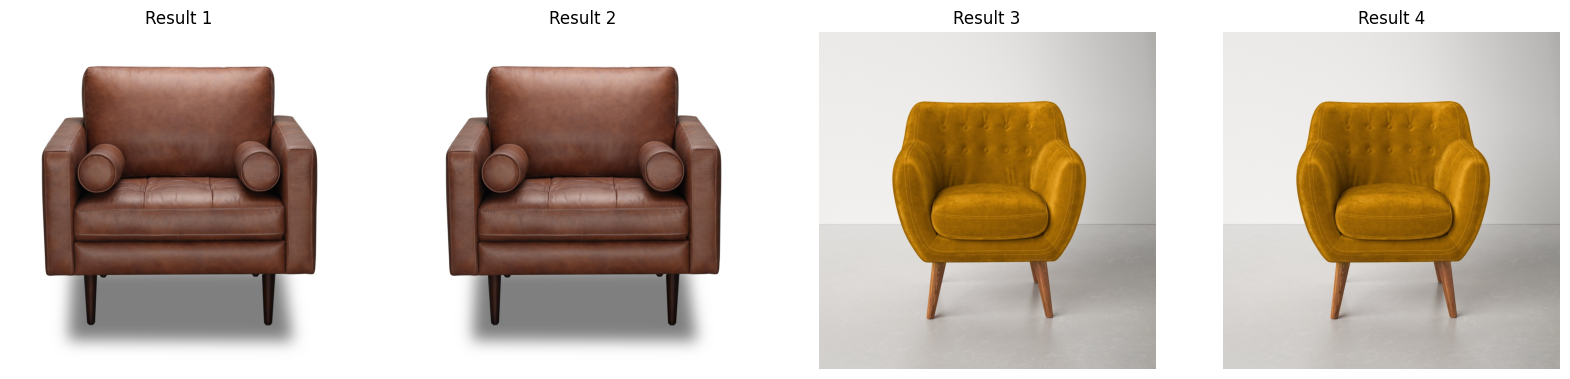

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Отображение топ-4 изображений
fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # 4 изображения в ряд
for i, img_path in enumerate(results["metadatas"][0]):
    img = mpimg.imread(img_path["image"])  # Загружаем изображение по пути
    axes[i].imshow(img)
    axes[i].axis("off")  # Отключаем оси
    axes[i].set_title(f"Result {i + 1}")

plt.tight_layout()
plt.show()